# Introduction

## Project Overview

This project analyzes customer data from a fictional telecommunications company (Telco) that provides mobile, internet, and related services.  
The dataset contains information about customer demographics, contract and billing detailsб as well as service usage patterns satisfaction.  

It also includes data which indicates whether the customer churned (left the service) or remained.  

The objective of this analysis is to explore the factors influencing churn and to develop a predictive model for identifying customers at risk of leaving.

---

## Project Goals

- Conduct exploratory data analysis to understand the data structure, feature distributions, and potential data quality issues.  
- Preprocess the data, including handling missing values and applying necessary transformations.  
- Engineer meaningful features to enhance model performance.  
- Build and evaluate predictive models to accurately forecast students' final exam scores.  
- Interpret the results to identify key factors affecting exam performance.  
- Visualize insights for effective communication with stakeholders.  
- Develop an interpretable and reproducible modeling pipeline.  
- Provide actionable recommendations based on the model findings.

# Preparations

## Step Overview

**In this step, we prepare everything necessary for our work, including:**

- Importing all required libraries (e.g., basic, advanced and custom)
- Setting system options for better data handling and display
- Loading and merging datasets

## 1. Imports

In [1]:
# Basic
import numpy as np
import pandas as pd
import openpyxl
import warnings

# Data Preparation
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy


# Modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



# Custom
from utility_functions.parameters import do_random_grid_search, assemble_models_after_grid_search

from utility_functions.logger import get_logger
from utility_functions.data_check import check_datasets_before_merge, detect_missing_values
from utility_functions.stats_analysis import (
    evaluate_kurtosis, 
    generate_skew_instructions, 
    identify_outliers, 
    compare_columns, 
    describe_disc_features, 
    calculate_vif)

from utility_functions.visualization import create_countplots, create_histplots

from utility_functions.preprocessing import (
    target_splitter, 
    classify_columns,
    set_encoding_col_transformer,
    set_preprocessing_pipeline_steps,
)

from utility_functions.modeling import (
    create_basic_models, 
    evaluate_regression_models, 
    evaluate_binary_class_models, 
    evaluate_multi_class_models,
    evaluate_final_regression_models, 
    evaluate_final_binary_class_models, 
    evaluate_final_multi_class_models,
    get_baseline_scores
)

from utility_functions.feature_selection import feature_selection_orchestrator

from utility_transformers.transformers import (
    StandardizeStringValues, 
    FixedColumnDiscretization, 
    QuantileColumnDiscretization, 
    PositiveValueFlagTransformer, 
    SkewedFeaturesTransformer, 
    MappingTransformer,
    YesNoToBinaryMapper,
    UnusedFeaturesDropper,
    ArrayToDFTransformer,
    FrequencyEncoder,
    
)



## 2. Settings

In [2]:
logger = get_logger(__name__)

logger.info("=========================================\n")
logger.info("========== NEW SESSION STARTED ==========\n")
logger.info("=========================================\n")
logger.info("Libraries imported successfully.")
logger.info("="*40)

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')  # white, dark, whitegrid, darkgrid, ticks
sns.set_palette('pastel') # deep, muted, bright, pastel, dark, colorblind

warnings.filterwarnings("ignore", message="Could not find the number of physical cores*")

logger.info("Settings applied successfully.")
logger.info("="*40)


>> INFO    : =========================================

>> INFO    : ========== NEW SESSION STARTED ==========

>> INFO    : =========================================

>> INFO    : Libraries imported successfully.
>> INFO    : ========================================
>> INFO    : Settings applied successfully.
>> INFO    : ========================================


## 3. Data Loading and Merge

### Data Loading

In [3]:
basic_raw = pd.read_excel("datasets/CustomerChurn.xlsx")
demographic_raw = pd.read_excel("datasets/Telco_customer_churn_demographics.xlsx")
population_raw = pd.read_excel("datasets/Telco_customer_churn_population.xlsx")
location_raw = pd.read_excel("datasets/Telco_customer_churn_location.xlsx")
services_raw = pd.read_excel("datasets/Telco_customer_churn_services.xlsx")
status_raw = pd.read_excel("datasets/Telco_customer_churn_status.xlsx")

### 3.1 Merge: Step 1 | basic_raw + demographic_raw

In [4]:
basic_raw.sample()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
612,677632,2804-ETQDK,No,No,Yes,66,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.55,1357.1,No


In [5]:
demographic_raw.sample()

,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
3640,5136-RGMZO,1,Male,39,No,No,No,No,0


In [6]:
check_datasets_before_merge(first_df=basic_raw, second_df=demographic_raw, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
Issues found:
- Duplicated columns (except 'Customer ID'): ['Dependents', 'Senior Citizen']

Datasets are NOT ready to be merged.
------------------------------------------------------


In [7]:
demographic_raw = demographic_raw.drop(columns=['Senior Citizen', 'Dependents'])
check_datasets_before_merge(first_df=basic_raw, second_df=demographic_raw, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
No issues found. Datasets are ready to be merged.
first_df shape : (7043, 21)
second_df shape: (7043, 7)
Expected merged shape: (7043, 27)
------------------------------------------------------


In [8]:
basic_merged = pd.merge(basic_raw, demographic_raw, on='Customer ID', how='inner')
logger.info("'basic_merged' was successfully updated by merging with 'demographic_raw'")
logger.info(f"Updated Shape: {basic_merged.shape}")
logger.info("="*40)

>> INFO    : 'basic_merged' was successfully updated by merging with 'demographic_raw'
>> INFO    : Updated Shape: (7043, 27)
>> INFO    : ========================================


###  3.2 Merge: Step 2 | basic_merged+ location_raw

In [9]:
basic_merged.sample()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn,Count,Gender,Age,Under 30,Married,Number of Dependents
3535,540551,3612-YUNGG,No,Yes,Yes,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),109.2,6741.15,No,1,Male,53,No,Yes,1


In [10]:
location_raw.sample()

,Location ID,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude
1678,MQZPSO6862,7598-UAASY,1,United States,California,Marshall,94940,"38.129308, -122.834815",38.129308,-122.834815


In [11]:
check_datasets_before_merge(basic_merged, location_raw, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
Issues found:
- Duplicated columns (except 'Customer ID'): ['Count']

Datasets are NOT ready to be merged.
------------------------------------------------------


In [12]:
print(basic_merged['Count'].nunique())
print(location_raw['Count'].nunique())

1
1


In [13]:
location_raw = location_raw.drop(columns=['Count'])

In [14]:
check_datasets_before_merge(basic_merged, location_raw, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
No issues found. Datasets are ready to be merged.
first_df shape : (7043, 27)
second_df shape: (7043, 9)
Expected merged shape: (7043, 35)
------------------------------------------------------


In [15]:
basic_merged = pd.merge(basic_merged, location_raw, on='Customer ID', how='inner')
logger.info("'basic_merged' was successfully updated by merging with 'location_raw'")
logger.info(f"Updated Shape: {basic_merged.shape}")
logger.info("="*40)

>> INFO    : 'basic_merged' was successfully updated by merging with 'location_raw'
>> INFO    : Updated Shape: (7043, 35)
>> INFO    : ========================================


### 3.3 Merge: Step 3 | basic_merged + population_raw

In [16]:
basic_merged.sample()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn,Count,Gender,Age,Under 30,Married,Number of Dependents,Location ID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude
6784,385776,9546-KDTRB,No,No,No,19,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),24.7,465.85,No,1,Female,62,No,No,0,KDQDJT5681,United States,California,Pasadena,91106,"34.139402, -118.128658",34.139402,-118.128658


In [17]:
population_raw.sample()

,ID,Zip Code,Population
494,495,92411,23146


In [18]:
# so far its okay to have duplicates and not identical columns for Zip Code, 
# we will consider only 2 factors here:
# 1) both datasets containing uniting columns,
# 2) there are no missing values in both of them

check_datasets_before_merge(basic_merged, population_raw, uniting_column='Zip Code')


Final check for merging datasets on 'Zip Code':
------------------------------------------------------
Issues found:
- Duplicates in 'Zip Code': 5418 in first_df, 0 in second_df
- Values in 'Zip Code' do not match between datasets

Datasets are NOT ready to be merged.
------------------------------------------------------


In [19]:
try:
    basic_merged = pd.merge(basic_merged, population_raw, on='Zip Code', how='left')
except Exception as e:
    logger.error(f"'basic_merged' was NOT updated by merging with 'population_raw' due to error: {type(e).__name__} --- {e}")
    logger.info("="*40)
else:
    logger.info("'basic_merged' was successfully updated by merging with 'population_raw'")
    logger.info(f"Updated Shape: {basic_merged.shape}")
    logger.info("="*40)

>> INFO    : 'basic_merged' was successfully updated by merging with 'population_raw'
>> INFO    : Updated Shape: (7043, 37)
>> INFO    : ========================================


### 3.4 Merge: Step 4 | basic_merged + service_raw

In [20]:
basic_merged.sample()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn,Count,Gender,Age,Under 30,Married,Number of Dependents,Location ID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,ID,Population
5891,691737,4905-JEFDW,No,No,No,11,No,No phone service,DSL,No,No,Yes,No,Yes,No,One year,Yes,Electronic check,41.6,470.6,Yes,1,Male,39,No,No,0,UDLKRX9396,United States,California,Palo Alto,94306,"37.416159, -122.131337",37.416159,-122.131337,944,24492


In [21]:
services_raw.sample()

,Service ID,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
6648,UFFXATXFV9483,3926-YZVVX,1,Q3,No,0,41,NaN,Yes,12.42,No,Yes,Cable,12,No,No,No,Yes,No,No,No,Yes,One Year,No,Bank Withdrawal,50.05,2029.05,0.0,0,509.22,2538.27


In [22]:
check_datasets_before_merge(basic_merged, services_raw, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
Issues found:
- Missing values in second_df:
Offer            3877
Internet Type    1526
dtype: int64
- Duplicated columns (except 'Customer ID'): ['Internet Service', 'Multiple Lines', 'Phone Service', 'Contract', 'Count', 'Streaming TV', 'Paperless Billing', 'Payment Method', 'Online Security', 'Online Backup', 'Total Charges', 'Streaming Movies']

Datasets are NOT ready to be merged.
------------------------------------------------------


In [23]:
services_prep = services_raw.drop(columns=['Contract', 'Paperless Billing', 'Total Charges', 'Internet Service', 'Online Security', 'Online Backup', 'Multiple Lines', 'Payment Method', 'Streaming TV', 'Streaming Movies', 'Phone Service', 'Count'])

In [24]:
check_datasets_before_merge(basic_merged, services_prep, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
Issues found:
- Missing values in second_df:
Offer            3877
Internet Type    1526
dtype: int64

Datasets are NOT ready to be merged.
------------------------------------------------------


In [25]:
for col in ['Offer', 'Internet Type']:
    print(services_prep[col].value_counts(dropna=False))
    print()

Offer
NaN        3877
Offer B     824
Offer E     805
Offer D     602
Offer A     520
Offer C     415
Name: count, dtype: int64

Internet Type
Fiber Optic    3035
DSL            1652
NaN            1526
Cable           830
Name: count, dtype: int64



In [26]:
services_prep[services_prep['Offer'].isna()]['Internet Type'].value_counts(dropna=False)

Internet Type
Fiber Optic    1664
DSL             909
NaN             853
Cable           451
Name: count, dtype: int64

In [27]:
services_prep['Offer'] = services_prep['Offer'].fillna('No Offer')
services_prep['Internet Type'] = services_prep['Internet Type'].fillna('No Internet')
logger.info("services_prep: missing values in 'Offer' column: 3877")
logger.info("services_prep: missing values in 'Offer' replaced with 'No Offer'")
logger.info('='*40)
logger.info("services_prep: missing values in 'Internet Type' column: 853")
logger.info("services_prep: missing values in 'Internet Type' column replaced with 'No Internet'")
logger.info('='*40)


>> INFO    : services_prep: missing values in 'Offer' column: 3877
>> INFO    : services_prep: missing values in 'Offer' replaced with 'No Offer'
>> INFO    : ========================================
>> INFO    : services_prep: missing values in 'Internet Type' column: 853
>> INFO    : services_prep: missing values in 'Internet Type' column replaced with 'No Internet'
>> INFO    : ========================================


In [28]:
for col in ['Offer', 'Internet Type']:
    print(services_prep[col].value_counts(dropna=False))
    print()

Offer
No Offer    3877
Offer B      824
Offer E      805
Offer D      602
Offer A      520
Offer C      415
Name: count, dtype: int64

Internet Type
Fiber Optic    3035
DSL            1652
No Internet    1526
Cable           830
Name: count, dtype: int64



In [29]:
check_datasets_before_merge(basic_merged, services_prep, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
No issues found. Datasets are ready to be merged.
first_df shape : (7043, 37)
second_df shape: (7043, 19)
Expected merged shape: (7043, 55)
------------------------------------------------------


In [30]:
try:
    basic_merged = pd.merge(basic_merged, services_prep, on='Customer ID', how='inner')
except Exception as e:
    logger.error(f"'basic_merged' was NOT updated by merging with 'population_raw' due to error: {type(e).__name__} --- {e}")
    logger.info("="*40)
else:
    logger.info("'basic_merged' was successfully updated by merging with 'services_prep'")
    logger.info(f"Updated Shape: {basic_merged.shape}")
    logger.info("="*40)

>> INFO    : 'basic_merged' was successfully updated by merging with 'services_prep'
>> INFO    : Updated Shape: (7043, 55)
>> INFO    : ========================================


### 3.5 Merge: Step 5 | basic_merged + status_raw

In [31]:
basic_merged.sample()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn,Count,Gender,Age,Under 30,Married,Number of Dependents,Location ID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,ID,Population,Service ID,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Device Protection Plan,Premium Tech Support,Streaming Music,Unlimited Data,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
3748,947367,6339-RZCBJ,No,No,No,48,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),78.9,3771.5,No,1,Male,45,No,No,0,MWGPFH7931,United States,California,Colton,92324,"34.030915, -117.273201",34.030915,-117.273201,449,52202,NVKHRMWHH1775,Q3,No,0,48,No Offer,3.59,DSL,10,Yes,Yes,Yes,Yes,78.9,0.0,0,172.32,3943.82


In [32]:
status_raw.sample()

,Status ID,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
1297,ICPHRY1916,6275-YDUVO,1,Q3,3,Churned,Yes,1,95,2969,Attitude,Attitude of service provider


In [33]:
check_datasets_before_merge(basic_merged, status_raw, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
Issues found:
- Missing values in second_df:
Churn Category    5174
Churn Reason      5174
dtype: int64
- Duplicated columns (except 'Customer ID'): ['Quarter', 'Count']

Datasets are NOT ready to be merged.
------------------------------------------------------


In [34]:
status_prep = status_raw.drop(columns=['Count', 'Quarter'])
for col in ['Churn Category', 'Churn Reason']:
    print(status_prep[col].value_counts(dropna=False))
    print('\n'*2)

Churn Category
NaN                5174
Competitor          841
Attitude            314
Dissatisfaction     303
Price               211
Other               200
Name: count, dtype: int64



Churn Reason
NaN                                          5174
Competitor had better devices                 313
Competitor made better offer                  311
Attitude of support person                    220
Don't know                                    130
Competitor offered more data                  117
Competitor offered higher download speeds     100
Attitude of service provider                   94
Price too high                                 78
Product dissatisfaction                        77
Network reliability                            72
Long distance charges                          64
Service dissatisfaction                        63
Moved                                          46
Extra data charges                             39
Limited range of services                      37

In [35]:
basic_merged['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [36]:
status_prep['Churn Category'] = status_prep['Churn Category'].fillna("Still a Customer")
status_prep['Churn Reason'] = status_prep['Churn Category'].fillna("Still a Customer")
logger.info("'status_prep': missing values in 'Churn Category' column: 5174")
logger.info("'status_prep': missing values in 'Churn Category' column replaced with 'Still a Customer'")
logger.info('='*40)
logger.info("'status_prep': missing values in 'Churn Reason' column: 5174")
logger.info("'status_prep': missing values in 'Churn Reason' column replaced with 'Still a Customer'")
logger.info('='*40)

>> INFO    : 'status_prep': missing values in 'Churn Category' column: 5174
>> INFO    : 'status_prep': missing values in 'Churn Category' column replaced with 'Still a Customer'
>> INFO    : ========================================
>> INFO    : 'status_prep': missing values in 'Churn Reason' column: 5174
>> INFO    : 'status_prep': missing values in 'Churn Reason' column replaced with 'Still a Customer'
>> INFO    : ========================================


In [37]:
check_datasets_before_merge(basic_merged, status_prep, uniting_column='Customer ID')


Final check for merging datasets on 'Customer ID':
------------------------------------------------------
No issues found. Datasets are ready to be merged.
first_df shape : (7043, 55)
second_df shape: (7043, 10)
Expected merged shape: (7043, 64)
------------------------------------------------------


In [38]:
try:
    basic_merged = pd.merge(basic_merged, status_prep, on='Customer ID', how='inner')
except Exception as e:
    logger.error(f"'basic_merged' was NOT updated by merging with 'population_raw' due to error: {type(e).__name__} --- {e}")
    logger.info("="*40)
else:
    logger.info("'basic_merged' was successfully updated by merging with 'status_prep'")
    logger.info(f"Updated Shape: {basic_merged.shape}")
    logger.info("="*40)

>> INFO    : 'basic_merged' was successfully updated by merging with 'status_prep'
>> INFO    : Updated Shape: (7043, 64)
>> INFO    : ========================================


In [39]:
logger.info("All merges were successfully completed.")
logger.info("="*40)
logger.info("="*40)

>> INFO    : All merges were successfully completed.
>> INFO    : ========================================
>> INFO    : ========================================


# General Data Overview

## Step Overview

**Preprocessing**
- Reorder columns to improve readability and structure.
- Standardize string values for easier analysis and better code performance.  
- Rename long or inconsistent values into shorter, readable ones (e.g., payment methods).

**1. Data Samples**  
- Use `.head()` and `.sample()` to quickly review the data structure and values.  

**2. Column Selection**  
- Detect duplicate or highly similar columns.  
- Choose which ones to keep and drop the rest.

**3. Missing Data / Duplicates Handling**  
- Check for missing values and decide how to handle them.  
- Find duplicate `customer_id` entries and remove them if needed.
  
**4. Data Types Check**  
- Use `data.info()` to identify any issues with data types or incorrect assignments.

**5. Data Distribution**  
- Examine the distribution of values in numeric and categorical columns throughout the dataset.

**6. Target Identification**  
- Given the dataset's size and complexity, identify columns that may cause data leakage.
- Define potential target variables for modeling.

**7. Column Types**  
- Classify columns into seven categories:
      bool,
      binary numerical,
      binary categorical,
      discrete numerical,
      discrete categorical,
      high cardinality numerical,
      and high cardinality categorical.   

**8. Value Distributions by Type**  
- Analyze value distributions for each column category using `value_counts()` and appropriate visualizations.
 
**9. Target Distributions and Relations**  
- Analyze distributions of all target variables through `value_counts()` and visualizations.  
- Assess the relationship between `churn` and other target variables to identify significant correlations.

## 4. Data Overview

### Preproccessing

In [40]:
data_original = basic_merged.copy()
data = data_original.copy()

In [41]:
# lets organize columns for easier analysis

ordered_cols = [
    # ID
    'LoyaltyID', 'Customer ID', 'Service ID', 'Status ID', 'Location ID', 'ID',
    # Demographics
    'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Partner', 'Married', 'Dependents', 'Number of Dependents',
    # Location
    'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Population',
    # Account Info
    'Tenure', 'Tenure in Months', 'Contract', 'Paperless Billing', 'Payment Method',
    'Monthly Charges', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Revenue',
    'Total Extra Data Charges', 'Total Long Distance Charges',
    'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
    # Services
    'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type',
    'Online Security', 'Online Backup', 'Device Protection', 'Device Protection Plan',
    'Tech Support', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
    'Streaming Music', 'Unlimited Data',
    # Referrals / Offers
    'Referred a Friend', 'Number of Referrals', 'Offer',
    # Churn-related
    'Churn', 'Churn Label', 'Churn Value', 'Churn Score', 'Churn Category', 'Churn Reason', 'Customer Status',
    # KPIs
    'Satisfaction Score', 'CLTV',
    # Meta
    'Quarter', 'Count'
]

data = data[ordered_cols]

In [42]:
string_stadardizer = StandardizeStringValues()
data = string_stadardizer.fit_transform(data)

In [43]:
data.columns = data.columns.str.strip().str.lower().str.replace(r'\s+', '_', regex=True)

In [44]:
data['payment_method'].unique().tolist()
data['payment_method'] = data['payment_method'].replace({
    'electronic check':'e-check',
    'mailed check':'mail check',
    'bank transfer (automatic)':'bank transfer',
    'credit card (automatic)':'card'
})

### 4.1 Data Samples

In [45]:
data.head(1)

,loyaltyid,customer_id,service_id,status_id,location_id,id,gender,age,under_30,senior_citizen,partner,married,dependents,number_of_dependents,country,state,city,zip_code,lat_long,latitude,longitude,population,tenure,tenure_in_months,contract,paperless_billing,payment_method,monthly_charges,monthly_charge,total_charges,total_refunds,total_revenue,total_extra_data_charges,total_long_distance_charges,avg_monthly_long_distance_charges,avg_monthly_gb_download,phone_service,multiple_lines,internet_service,internet_type,online_security,online_backup,device_protection,device_protection_plan,tech_support,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,referred_a_friend,number_of_referrals,offer,churn,churn_label,churn_value,churn_score,churn_category,churn_reason,customer_status,satisfaction_score,cltv,quarter,count
0,318537,7590-vhveg,frzcgdegj1299,godtmi5747,kqvcvy8549,1,female,36,no,no,yes,yes,no,0,united states,california,los angeles,90001,"33.973616, -118.24902",33.973616,-118.24902,54492,1,1,month-to-month,yes,e-check,29.85,29.85,29.85,0.0,29.85,0,0.0,0.0,10,no,no phone service,dsl,dsl,no,yes,no,no,no,no,no,no,no,yes,no,0,offer e,no,no,0,27,still a customer,still a customer,joined,3,3964,q3,1


In [46]:
data.sample(5)

,loyaltyid,customer_id,service_id,status_id,location_id,id,gender,age,under_30,senior_citizen,partner,married,dependents,number_of_dependents,country,state,city,zip_code,lat_long,latitude,longitude,population,tenure,tenure_in_months,contract,paperless_billing,payment_method,monthly_charges,monthly_charge,total_charges,total_refunds,total_revenue,total_extra_data_charges,total_long_distance_charges,avg_monthly_long_distance_charges,avg_monthly_gb_download,phone_service,multiple_lines,internet_service,internet_type,online_security,online_backup,device_protection,device_protection_plan,tech_support,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,referred_a_friend,number_of_referrals,offer,churn,churn_label,churn_value,churn_score,churn_category,churn_reason,customer_status,satisfaction_score,cltv,quarter,count
250,186020,4075-jfpgr,ecozzuvel4854,hglrou5457,uhhmrt8559,251,female,27,yes,no,yes,yes,no,0,united states,california,rancho cucamonga,91730,"34.10097, -117.57882",34.100970,-117.578820,51970,51,51,one year,yes,e-check,93.50,93.50,4619.55,0.0,5694.12,0,1074.57,21.07,46,yes,no,fiber optic,fiber optic,yes,yes,yes,yes,no,no,yes,no,no,yes,yes,2,offer b,no,no,0,68,still a customer,still a customer,stayed,3,5561,q3,1
4489,357866,8259-dzliz,kioofsuow5947,xzzlgi1682,xmodec3763,1195,female,53,no,no,yes,yes,yes,2,united states,california,delhi,95315,"37.422961, -120.765493",37.422961,-120.765493,10159,64,64,one year,yes,bank transfer,53.85,53.85,3399.85,0.0,4492.33,0,1092.48,17.07,25,yes,yes,dsl,dsl,no,yes,no,no,no,no,no,no,no,yes,yes,10,offer b,no,no,0,36,still a customer,still a customer,stayed,4,4954,q3,1
5161,700573,0696-uktox,hlhbmwsne9543,lfscvb3565,irakav9453,206,male,64,no,no,no,no,yes,1,united states,california,north hills,91343,"34.238802, -118.482296",34.238802,-118.482296,57017,23,23,month-to-month,no,e-check,54.15,54.15,1312.45,0.0,1545.65,40,193.20,8.40,27,yes,no,dsl,cable,no,yes,no,no,yes,yes,no,no,no,no,no,0,no offer,no,no,0,80,still a customer,still a customer,stayed,4,2496,q3,1
4917,921403,6040-cgacy,dyosbqcvw5533,wlgiof1947,jyzzpq3346,1633,female,48,no,no,no,no,no,0,united states,california,blairsden graeagle,96103,"39.783747, -120.661032",39.783747,-120.661032,1839,15,15,month-to-month,no,mail check,19.60,19.60,299.4,0.0,897.45,0,598.05,39.87,0,yes,no,no,no internet,no internet service,no internet service,no internet service,no,no internet service,no,no internet service,no internet service,no,no,no,0,no offer,no,no,0,35,still a customer,still a customer,stayed,5,3195,q3,1
993,139204,9108-eqpnq,acrgeimse6195,gsqiub8478,cfkqsn6237,1002,female,27,yes,no,yes,yes,yes,2,united states,california,san leandro,94577,"37.717196, -122.159338",37.717196,-122.159338,41871,10,10,two year,no,card,26.10,26.10,225.55,0.0,411.25,0,185.70,18.57,0,yes,yes,no,no internet,no internet service,no internet service,no internet service,no,no internet service,no,no internet service,no internet service,no,no,yes,10,offer d,no,no,0,63,still a customer,still a customer,stayed,5,3179,q3,1


### 4.2 Columns Selection

In [47]:
compare_columns(data=data, features=['internet_service', 'internet_type'])

Comparison of columns: 
 ['internet_service', 'internet_type']
internet_service
fiber optic    3096
dsl            2421
no             1526
Name: count, dtype: int64

internet_type
fiber optic    3035
dsl            1652
no internet    1526
cable           830
Name: count, dtype: int64



In [48]:
compare_columns(data=data, features=['device_protection', 'device_protection_plan'])

Comparison of columns: 
 ['device_protection', 'device_protection_plan']
device_protection
no                     3095
yes                    2422
no internet service    1526
Name: count, dtype: int64

device_protection_plan
no     4621
yes    2422
Name: count, dtype: int64



In [49]:
compare_columns(data=data, features=['tech_support','premium_tech_support'])

Comparison of columns: 
 ['tech_support', 'premium_tech_support']
tech_support
no                     3473
yes                    2044
no internet service    1526
Name: count, dtype: int64

premium_tech_support
no     4999
yes    2044
Name: count, dtype: int64



In [50]:
compare_columns(data=data, features=['churn','churn_label','churn_value'])

Comparison of columns: 
 ['churn', 'churn_label', 'churn_value']
churn
no     5174
yes    1869
Name: count, dtype: int64

churn_label
no     5174
yes    1869
Name: count, dtype: int64

churn_value
0    5174
1    1869
Name: count, dtype: int64



In [51]:
compare_columns(data=data, features=['churn_category','churn_reason'])

Comparison of columns: 
 ['churn_category', 'churn_reason']
churn_category
still a customer    5174
competitor           841
attitude             314
dissatisfaction      303
price                211
other                200
Name: count, dtype: int64

churn_reason
still a customer    5174
competitor           841
attitude             314
dissatisfaction      303
price                211
other                200
Name: count, dtype: int64



In [52]:
data['customer_status'].value_counts(dropna=False, sort=True)

customer_status
stayed     4720
churned    1869
joined      454
Name: count, dtype: int64

In [53]:
print("Column that contain only 1 unique values:")
print('='*40)
for c in data.columns.tolist():
    if data[c].nunique() <= 1:
        print(c)

Column that contain only 1 unique values:
country
state
quarter
count


In [54]:
print("Comparing how equal are \n'partner' and 'married' columns")
print('='*40)
data[data['partner'] != data['married']]

Comparing how equal are 
'partner' and 'married' columns


,loyaltyid,customer_id,service_id,status_id,location_id,id,gender,age,under_30,senior_citizen,partner,married,dependents,number_of_dependents,country,state,city,zip_code,lat_long,latitude,longitude,population,tenure,tenure_in_months,contract,paperless_billing,payment_method,monthly_charges,monthly_charge,total_charges,total_refunds,total_revenue,total_extra_data_charges,total_long_distance_charges,avg_monthly_long_distance_charges,avg_monthly_gb_download,phone_service,multiple_lines,internet_service,internet_type,online_security,online_backup,device_protection,device_protection_plan,tech_support,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,referred_a_friend,number_of_referrals,offer,churn,churn_label,churn_value,churn_score,churn_category,churn_reason,customer_status,satisfaction_score,cltv,quarter,count


In [55]:
initial_cols_to_drop = [
    'loyaltyid',
    'service_id',
    'status_id',
    'location_id',
    'id',
    'dependents',
    'tenure',
    'monthly_charges',
    'lat_long', 
    'internet_service', 
    'device_protection', 
    'tech_support', 
    'referred_a_friend',
    'churn_label',
    'customer_status',
    'churn_reason',
    'count',
    'quarter',
    'country',
    'state',
    'married'
]
data = data.drop(columns=initial_cols_to_drop)
logger.info(f"Folowing columns were dropped: {initial_cols_to_drop}")
logger.info(f"Updated shape of dataframe: {data.shape}")
logger.info('='*40)

>> INFO    : Folowing columns were dropped: ['loyaltyid', 'service_id', 'status_id', 'location_id', 'id', 'dependents', 'tenure', 'monthly_charges', 'lat_long', 'internet_service', 'device_protection', 'tech_support', 'referred_a_friend', 'churn_label', 'customer_status', 'churn_reason', 'count', 'quarter', 'country', 'state', 'married']
>> INFO    : Updated shape of dataframe: (7043, 43)
>> INFO    : ========================================


In [56]:
data.head()

,customer_id,gender,age,under_30,senior_citizen,partner,number_of_dependents,city,zip_code,latitude,longitude,population,tenure_in_months,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_revenue,total_extra_data_charges,total_long_distance_charges,avg_monthly_long_distance_charges,avg_monthly_gb_download,phone_service,multiple_lines,internet_type,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,number_of_referrals,offer,churn,churn_value,churn_score,churn_category,satisfaction_score,cltv
0,7590-vhveg,female,36,no,no,yes,0,los angeles,90001,33.973616,-118.249020,54492,1,month-to-month,yes,e-check,29.85,29.85,0.0,29.85,0,0.00,0.00,10,no,no phone service,dsl,no,yes,no,no,no,no,no,yes,0,offer e,no,0,27,still a customer,3,3964
1,5575-gnvde,male,46,no,no,no,0,los angeles,90002,33.949255,-118.246978,44586,34,one year,no,mail check,56.95,1889.5,0.0,2470.56,0,581.06,17.09,16,yes,no,dsl,yes,no,yes,no,no,no,no,yes,0,no offer,no,0,61,still a customer,3,3441
2,3668-qpybk,male,37,no,no,no,0,los angeles,90003,33.964131,-118.272783,58198,2,month-to-month,yes,mail check,53.85,108.15,0.0,129.09,0,20.94,10.47,21,yes,no,dsl,yes,yes,no,no,no,no,no,yes,0,no offer,yes,1,86,competitor,1,3239
3,7795-cfocw,male,53,no,no,no,0,los angeles,90004,34.076259,-118.310715,67852,45,one year,no,bank transfer,42.30,1840.75,0.0,1840.75,0,0.00,0.00,10,no,no phone service,dsl,yes,no,yes,yes,no,no,no,yes,0,no offer,no,0,66,still a customer,3,4307
4,9237-hqitu,female,19,yes,no,no,2,los angeles,90005,34.059281,-118.307420,43019,2,month-to-month,yes,e-check,70.70,151.65,0.0,169.89,0,18.24,9.12,51,yes,no,fiber optic,no,no,no,no,no,no,no,yes,0,no offer,yes,1,67,other,2,2701


### 4.3 Missing Data / Duplicates Handling

In [57]:
detect_missing_values(data=data)

No missing values detected!


In [58]:
print(data.duplicated()[lambda x: x==True])
print(data.duplicated(subset='customer_id')[lambda x: x==True])

Series([], dtype: bool)
Series([], dtype: bool)


## 5. Statistical Reports Of Dataset

### 5.1 Dataset Information

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   under_30                           7043 non-null   object 
 4   senior_citizen                     7043 non-null   object 
 5   partner                            7043 non-null   object 
 6   number_of_dependents               7043 non-null   int64  
 7   city                               7043 non-null   object 
 8   zip_code                           7043 non-null   int64  
 9   latitude                           7043 non-null   float64
 10  longitude                          7043 non-null   float64
 11  population                         7043 non-null   int64

### 5.2 Handling 'Total Charges' wrong data type

In [60]:
data['total_charges']

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: total_charges, Length: 7043, dtype: object

In [61]:
data.loc[:,'total_charges'].apply(type).value_counts() 

total_charges
<class 'str'>    7043
Name: count, dtype: int64

In [62]:
data.loc[:,'total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')

In [63]:
detect_missing_values(data)

Some missing values were detected!


,missing_count,missing_%
total_charges,11,0.156183


In [64]:
data = data.dropna()
logger.info(f"Updated shape of dataframe is: {data.shape}")

>> INFO    : Updated shape of dataframe is: (7032, 43)


In [65]:
detect_missing_values(data)

No missing values detected!


In [66]:
data['total_charges'] = data['total_charges'].astype('float')

In [67]:
data.head()

,customer_id,gender,age,under_30,senior_citizen,partner,number_of_dependents,city,zip_code,latitude,longitude,population,tenure_in_months,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_revenue,total_extra_data_charges,total_long_distance_charges,avg_monthly_long_distance_charges,avg_monthly_gb_download,phone_service,multiple_lines,internet_type,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,number_of_referrals,offer,churn,churn_value,churn_score,churn_category,satisfaction_score,cltv
0,7590-vhveg,female,36,no,no,yes,0,los angeles,90001,33.973616,-118.249020,54492,1,month-to-month,yes,e-check,29.85,29.85,0.0,29.85,0,0.00,0.00,10,no,no phone service,dsl,no,yes,no,no,no,no,no,yes,0,offer e,no,0,27,still a customer,3,3964
1,5575-gnvde,male,46,no,no,no,0,los angeles,90002,33.949255,-118.246978,44586,34,one year,no,mail check,56.95,1889.50,0.0,2470.56,0,581.06,17.09,16,yes,no,dsl,yes,no,yes,no,no,no,no,yes,0,no offer,no,0,61,still a customer,3,3441
2,3668-qpybk,male,37,no,no,no,0,los angeles,90003,33.964131,-118.272783,58198,2,month-to-month,yes,mail check,53.85,108.15,0.0,129.09,0,20.94,10.47,21,yes,no,dsl,yes,yes,no,no,no,no,no,yes,0,no offer,yes,1,86,competitor,1,3239
3,7795-cfocw,male,53,no,no,no,0,los angeles,90004,34.076259,-118.310715,67852,45,one year,no,bank transfer,42.30,1840.75,0.0,1840.75,0,0.00,0.00,10,no,no phone service,dsl,yes,no,yes,yes,no,no,no,yes,0,no offer,no,0,66,still a customer,3,4307
4,9237-hqitu,female,19,yes,no,no,2,los angeles,90005,34.059281,-118.307420,43019,2,month-to-month,yes,e-check,70.70,151.65,0.0,169.89,0,18.24,9.12,51,yes,no,fiber optic,no,no,no,no,no,no,no,yes,0,no offer,yes,1,67,other,2,2701


### 5.3 Describe methods of num and cat features

In [68]:
data.drop(columns='customer_id').describe(include='object')

,gender,under_30,senior_citizen,partner,city,contract,paperless_billing,payment_method,phone_service,multiple_lines,internet_type,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,offer,churn,churn_category
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,2,2,2,2,1106,3,2,4,2,3,4,3,3,2,2,3,3,2,2,6,2,6
top,male,no,no,no,los angeles,month-to-month,yes,e-check,yes,no,fiber optic,no,no,no,no,no,no,no,yes,no offer,no,still a customer
freq,3549,5635,5890,3639,292,3875,4168,2365,6352,3385,3035,3497,3087,4614,4992,2809,2781,4545,4740,3869,5163,5163


In [69]:
data.drop(columns=['latitude','longitude']).describe(include='number')

,age,number_of_dependents,zip_code,population,tenure_in_months,monthly_charge,total_charges,total_refunds,total_revenue,total_extra_data_charges,total_long_distance_charges,avg_monthly_long_distance_charges,avg_monthly_gb_download,number_of_referrals,churn_value,churn_score,satisfaction_score,cltv
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.00000,7032.000000,7032.000000
mean,46.521331,0.467577,93487.082907,22124.511092,32.421786,64.798208,2283.300441,1.965252,3038.163730,6.871445,749.957096,22.963471,20.531712,1.949232,0.265785,58.52062,3.243885,4401.445108
std,16.751596,0.962134,1856.494074,21131.532328,24.545260,30.085974,2266.771362,7.908412,2865.830234,25.123141,847.025001,15.449368,20.419561,3.001324,0.441782,21.17591,1.202019,1182.414266
min,19.000000,0.000000,90001.000000,11.000000,1.000000,18.250000,18.800000,0.000000,21.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.00000,1.000000,2003.000000
25%,32.000000,0.000000,92101.750000,2344.000000,9.000000,35.587500,401.450000,0.000000,607.275000,0.000000,70.567500,9.210000,3.000000,0.000000,0.000000,40.00000,3.000000,3469.750000
50%,46.000000,0.000000,93518.000000,17524.000000,29.000000,70.350000,1397.475000,0.000000,2111.300000,0.000000,403.875000,22.890000,17.000000,0.000000,0.000000,61.00000,3.000000,4527.500000
75%,60.000000,0.000000,95329.250000,36125.000000,55.000000,89.862500,3794.737500,0.000000,4808.797500,0.000000,1192.432500,36.412500,27.000000,3.000000,1.000000,76.00000,4.000000,5381.000000
max,80.000000,9.000000,96150.000000,105285.000000,72.000000,118.750000,8684.800000,49.790000,11979.340000,150.000000,3564.720000,49.990000,85.000000,11.000000,1.000000,96.00000,5.000000,6500.000000


## 6. Features Disribution Analysis

### 6.1 Columns Separation

In [70]:
target_list = ['churn', 'churn_value', 'churn_score', 'churn_category', 'satisfaction_score', 'cltv']
columns_segmentation = classify_columns(data=data.drop(columns=target_list).copy(), nunique_threshold=12)

In [71]:
for col_type, columns in columns_segmentation.items():
    print(col_type)
    print(columns)
    print('='*60)

bool_cols
[]
binary_num_cols
[]
binary_cat_cols
['gender', 'under_30', 'senior_citizen', 'partner', 'paperless_billing', 'phone_service', 'device_protection_plan', 'premium_tech_support', 'streaming_music', 'unlimited_data']
discrete_num_cols
['number_of_dependents', 'number_of_referrals']
discrete_cat_cols
['contract', 'payment_method', 'multiple_lines', 'internet_type', 'online_security', 'online_backup', 'streaming_tv', 'streaming_movies', 'offer']
num_cols
['age', 'zip_code', 'latitude', 'longitude', 'population', 'tenure_in_months', 'monthly_charge', 'total_charges', 'total_refunds', 'total_revenue', 'total_extra_data_charges', 'total_long_distance_charges', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download']
cat_cols
['customer_id', 'city']


In [72]:
bool_cols = columns_segmentation['bool_cols']
binary_cat_cols = columns_segmentation['binary_cat_cols']
discrete_num_cols = columns_segmentation['discrete_num_cols']
discrete_cat_cols = columns_segmentation['discrete_cat_cols']
num_cols = columns_segmentation['num_cols']
cat_cols = columns_segmentation['cat_cols']

### 6.2 Categorical Features Counts

In [73]:
# binary cat cols
describe_disc_features(data=data, features=binary_cat_cols)

Describing discrete categorical features:
Column: 'gender'
gender
male      3549
female    3483
Name: count, dtype: int64
2 unique values.
----------------------------------------
Column: 'under_30'
under_30
no     5635
yes    1397
Name: count, dtype: int64
2 unique values.
----------------------------------------
Column: 'senior_citizen'
senior_citizen
no     5890
yes    1142
Name: count, dtype: int64
2 unique values.
----------------------------------------
Column: 'partner'
partner
no     3639
yes    3393
Name: count, dtype: int64
2 unique values.
----------------------------------------
Column: 'paperless_billing'
paperless_billing
yes    4168
no     2864
Name: count, dtype: int64
2 unique values.
----------------------------------------
Column: 'phone_service'
phone_service
yes    6352
no      680
Name: count, dtype: int64
2 unique values.
----------------------------------------
Column: 'device_protection_plan'
device_protection_plan
no     4614
yes    2418
Name: count, dtype: in

In [74]:
# discrete cat cols
describe_disc_features(data=data, features=discrete_cat_cols)

Describing discrete categorical features:
Column: 'contract'
contract
month-to-month    3875
two year          1685
one year          1472
Name: count, dtype: int64
3 unique values.
----------------------------------------
Column: 'payment_method'
payment_method
e-check          2365
mail check       1604
bank transfer    1542
card             1521
Name: count, dtype: int64
4 unique values.
----------------------------------------
Column: 'multiple_lines'
multiple_lines
no                  3385
yes                 2967
no phone service     680
Name: count, dtype: int64
3 unique values.
----------------------------------------
Column: 'internet_type'
internet_type
fiber optic    3035
dsl            1648
no internet    1520
cable           829
Name: count, dtype: int64
4 unique values.
----------------------------------------
Column: 'online_security'
online_security
no                     3497
yes                    2015
no internet service    1520
Name: count, dtype: int64
3 unique val

In [75]:
# cat cols
data[cat_cols].nunique()

customer_id    7032
city           1106
dtype: int64

### 6.3 Numerical Features Counts

In [76]:
# discrete num cols
describe_disc_features(data=data, features=discrete_num_cols)

Describing discrete categorical features:
Column: 'number_of_dependents'
number_of_dependents
0    5412
1     550
2     529
3     515
5      10
4       9
6       3
7       2
8       1
9       1
Name: count, dtype: int64
10 unique values.
----------------------------------------
Column: 'number_of_referrals'
number_of_referrals
0     3819
1     1086
5      261
3      254
7      248
9      238
4      235
2      234
10     223
6      220
8      212
11       2
Name: count, dtype: int64
12 unique values.
----------------------------------------


### 6.4 Categorical Features Plots

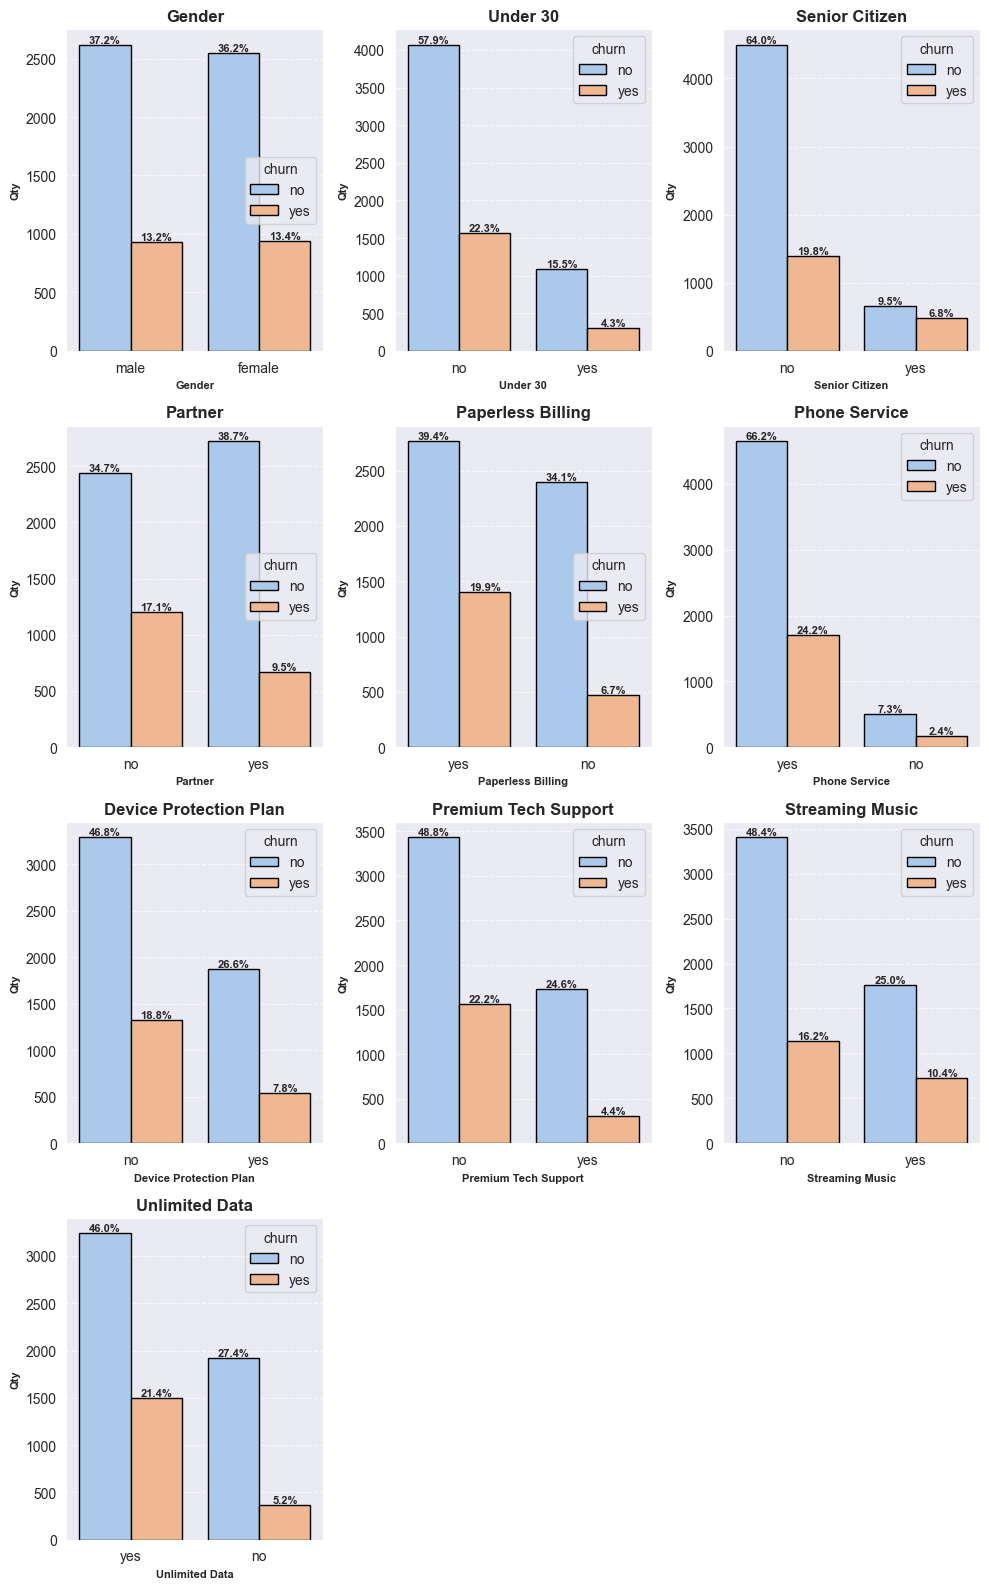

In [225]:
create_countplots(data=data, features=binary_cat_cols, hue='churn', ax_cols=3)

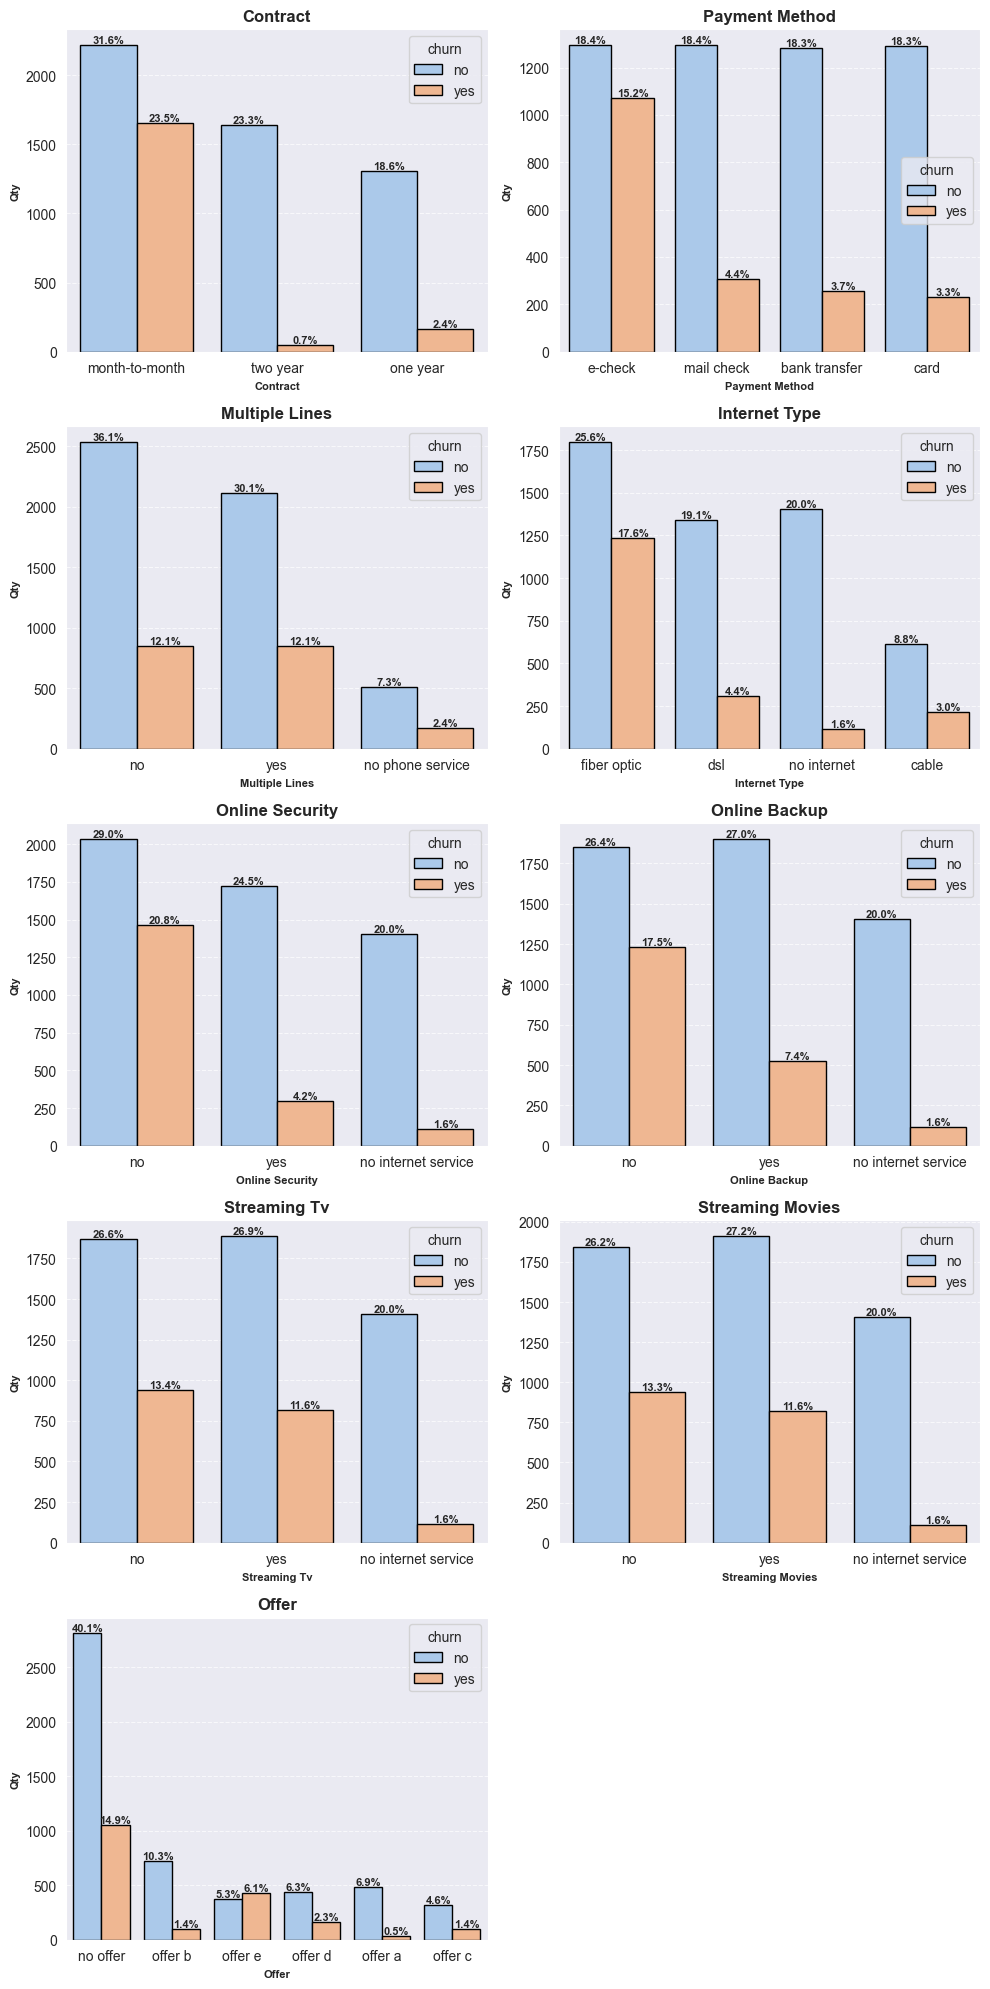

In [226]:
create_countplots(data=data, features=discrete_cat_cols, hue='churn', ax_cols=2)

### 6.5 Numerical Features Plots

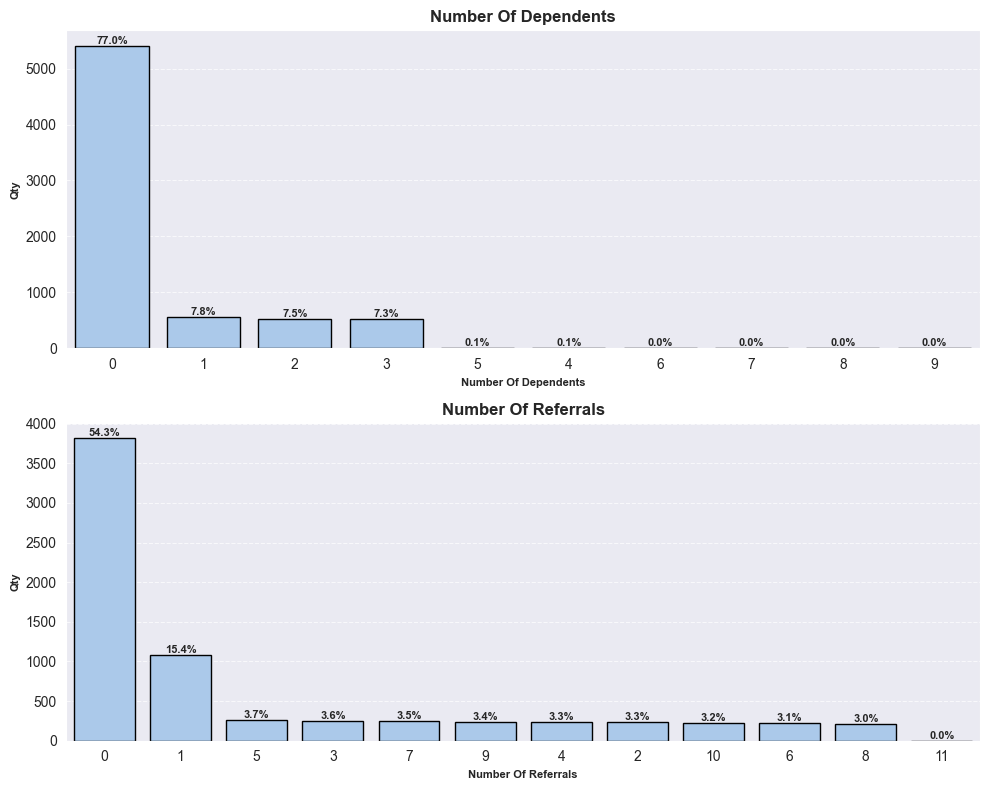

In [230]:
create_countplots(data=data, features=discrete_num_cols, ax_cols=1)

In [80]:
cols_not_to_plot = ['latitude', 'longitude', 'zip_code']
num_cols_to_plot = [col for col in num_cols if col not in cols_not_to_plot]
num_cols_to_plot

['age',
 'population',
 'tenure_in_months',
 'monthly_charge',
 'total_charges',
 'total_refunds',
 'total_revenue',
 'total_extra_data_charges',
 'total_long_distance_charges',
 'avg_monthly_long_distance_charges',
 'avg_monthly_gb_download']

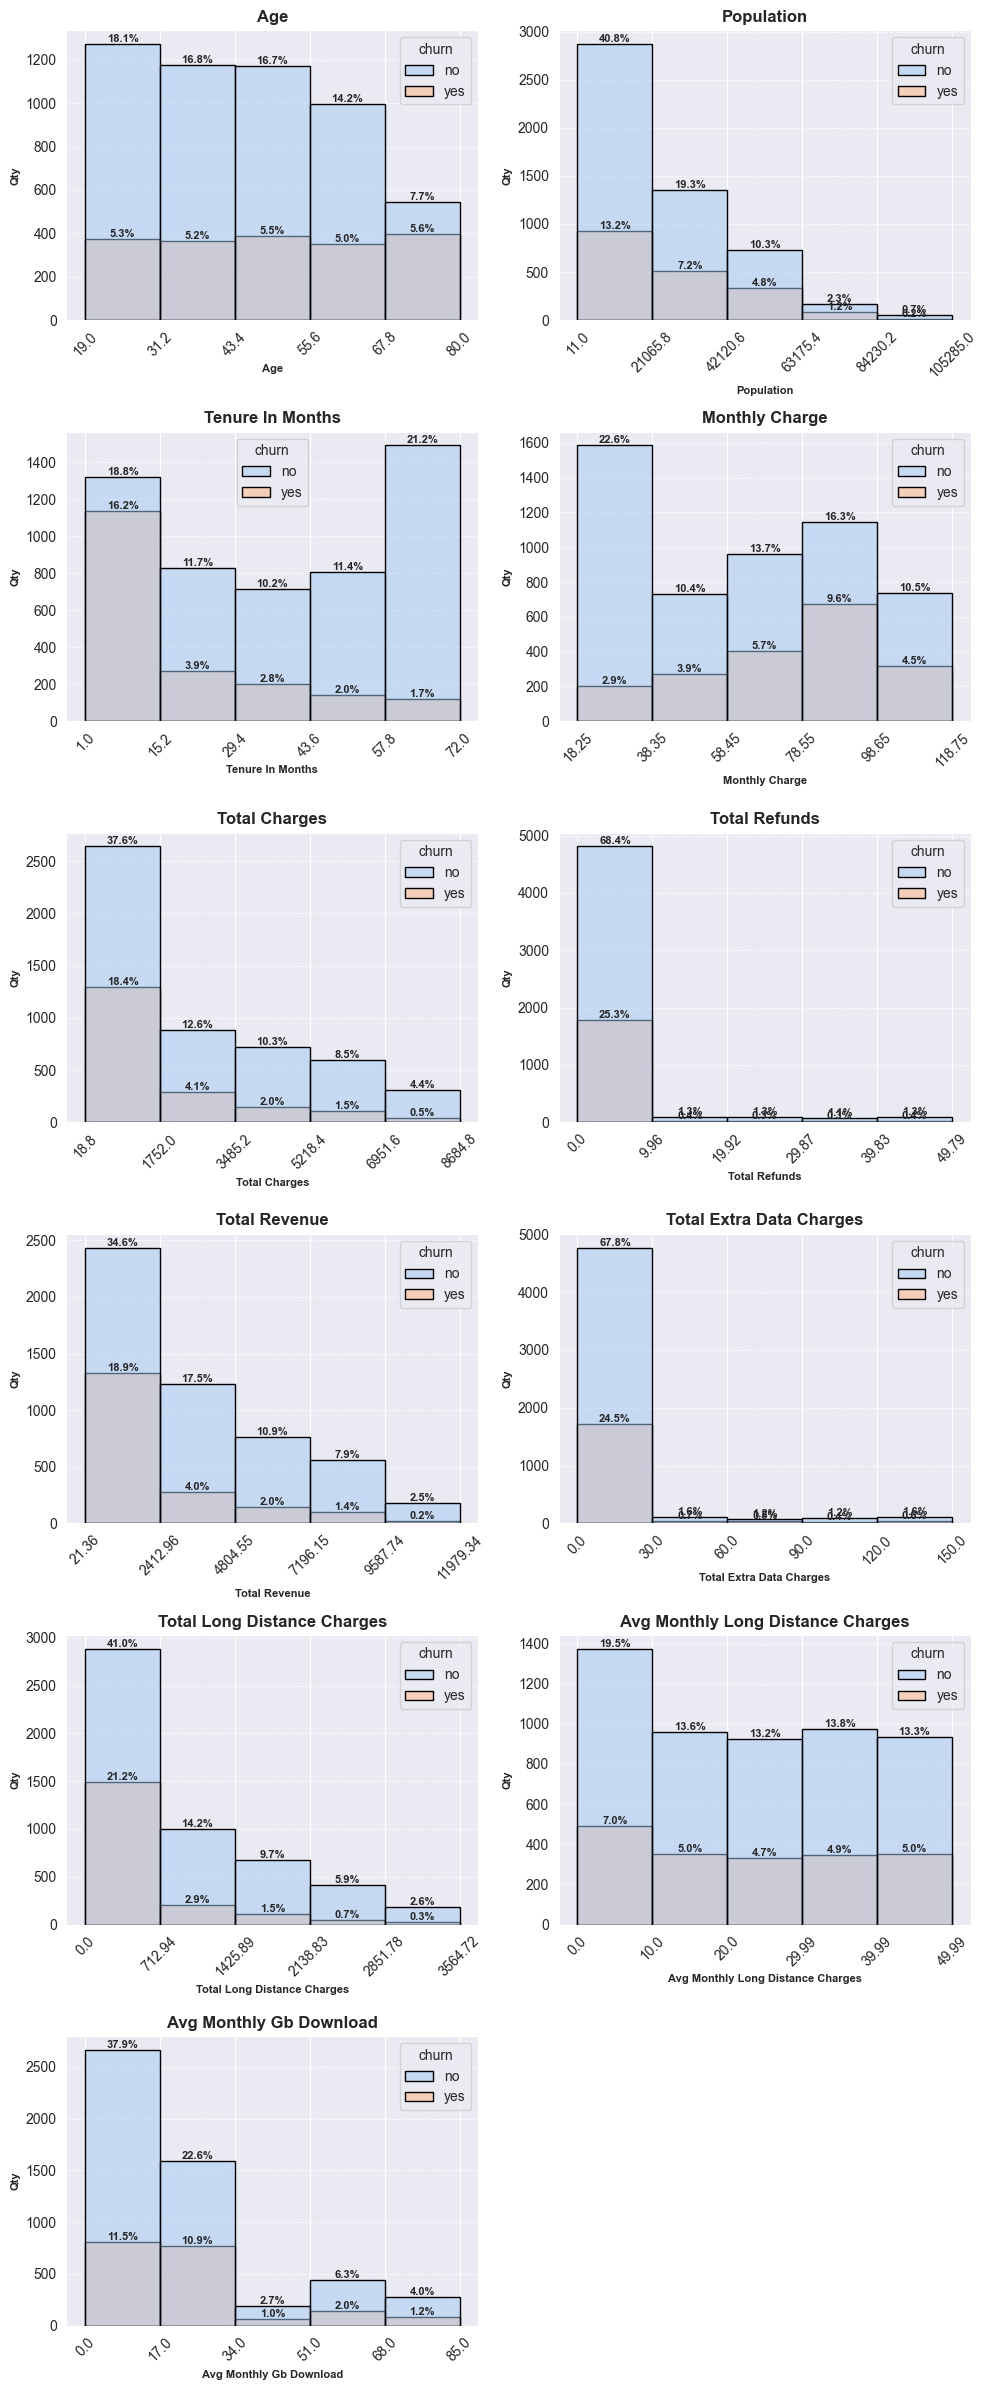

In [231]:
create_histplots(data=data, features=num_cols_to_plot, ax_cols=2, bins=5, hue='churn')

### 6.6 Other Hue Plots

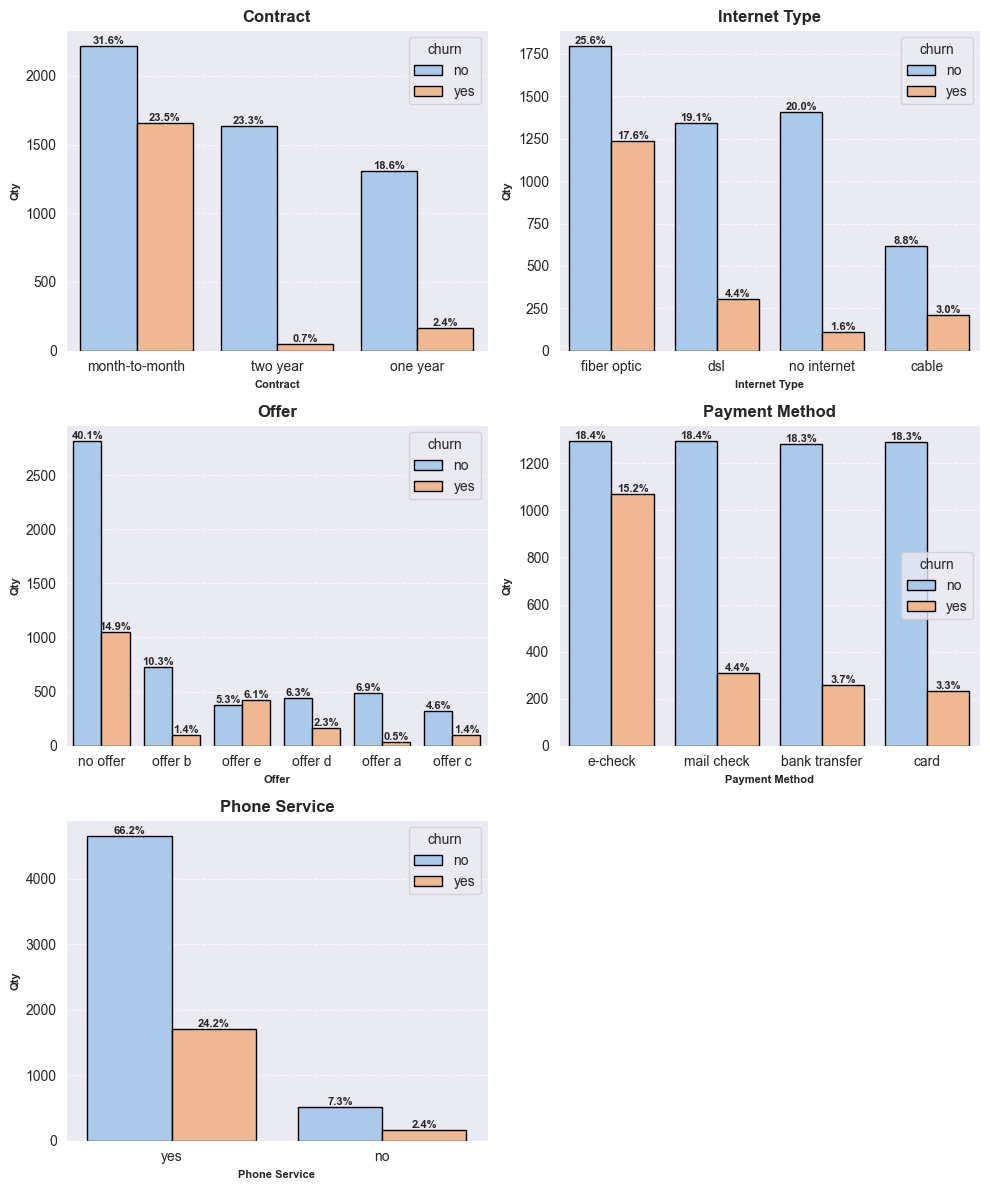

In [220]:
create_countplots(data=data, features=['contract','internet_type','offer','payment_method', 'phone_service'], hue='churn', ax_cols=2)

## 7. Target Distribution Analysis

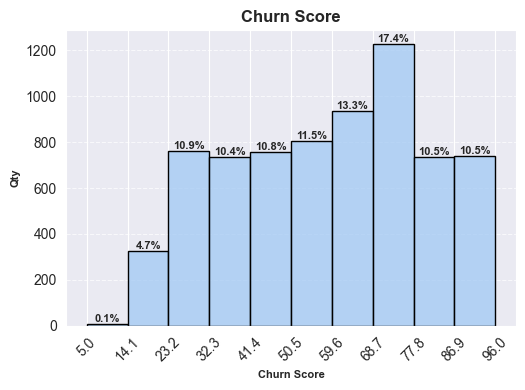

In [277]:
create_histplots(data=data, features=['churn_score'])

In [84]:
target_dict = target_splitter(data=data, target_list=target_list)

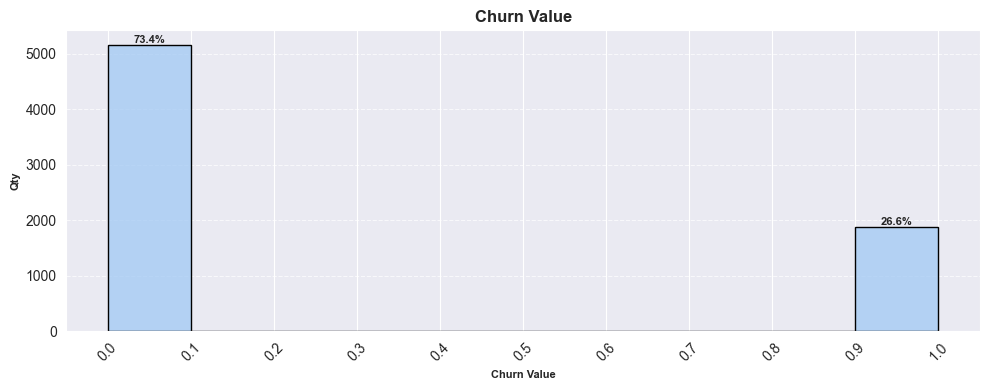

churn_value
(-0.001, 0.1]    5163 | 73.42%
(0.1, 0.2]            0 | 0.0%
(0.2, 0.3]            0 | 0.0%
(0.3, 0.4]            0 | 0.0%
(0.4, 0.5]            0 | 0.0%
(0.5, 0.6]            0 | 0.0%
(0.6, 0.7]            0 | 0.0%
(0.7, 0.8]            0 | 0.0%
(0.8, 0.9]            0 | 0.0%
(0.9, 1.0]       1869 | 26.58%
Name: count, dtype: object


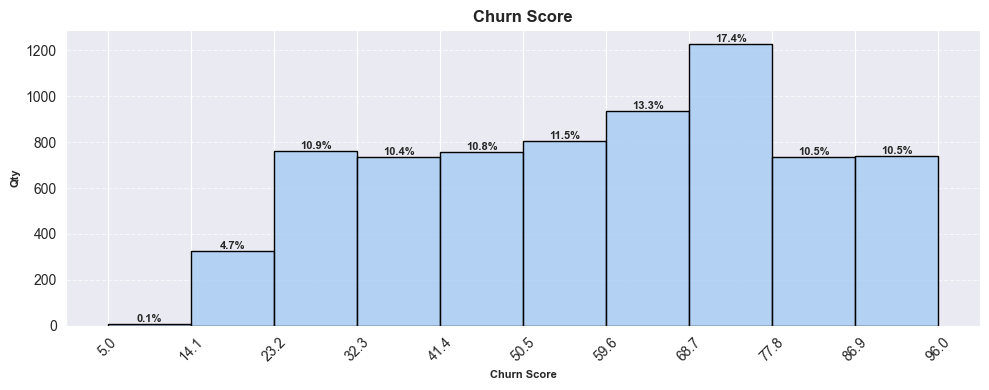

churn_score
(4.909, 14.1]        8 | 0.11%
(14.1, 23.2]       327 | 4.65%
(23.2, 32.3]      763 | 10.85%
(32.3, 41.4]      734 | 10.44%
(41.4, 50.5]      757 | 10.77%
(50.5, 59.6]      806 | 11.46%
(59.6, 68.7]       935 | 13.3%
(68.7, 77.8]     1226 | 17.43%
(77.8, 86.9]      735 | 10.45%
(86.9, 96.0]      741 | 10.54%
Name: count, dtype: object


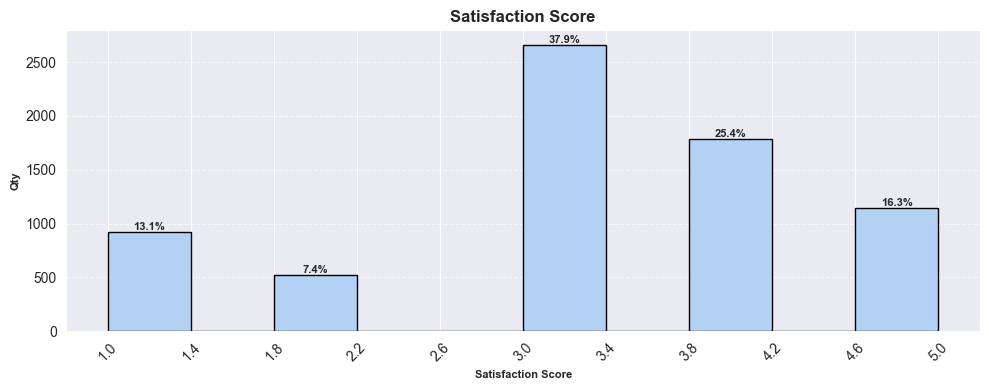

satisfaction_score
(0.996, 1.4]     922 | 13.11%
(1.4, 1.8]           0 | 0.0%
(1.8, 2.2]        518 | 7.37%
(2.2, 2.6]           0 | 0.0%
(2.6, 3.0]      2662 | 37.86%
(3.0, 3.4]           0 | 0.0%
(3.4, 3.8]           0 | 0.0%
(3.8, 4.2]      1783 | 25.36%
(4.2, 4.6]           0 | 0.0%
(4.6, 5.0]      1147 | 16.31%
Name: count, dtype: object


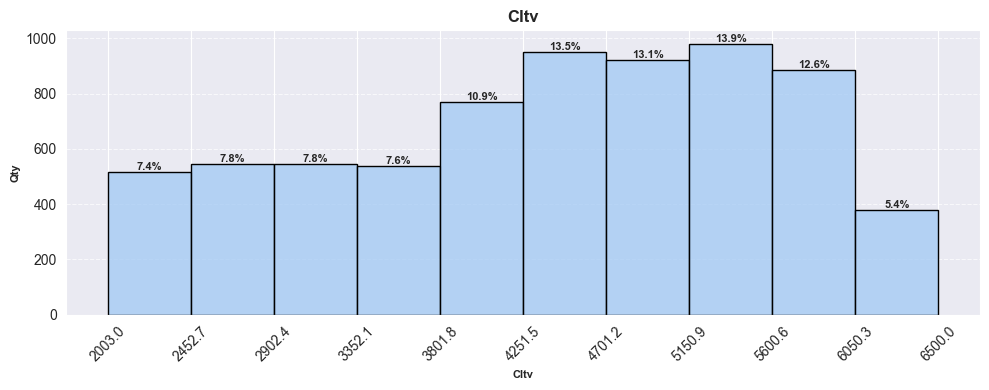

cltv
(1998.503, 2452.7]     517 | 7.35%
(2452.7, 2902.4]       545 | 7.75%
(2902.4, 3352.1]       547 | 7.78%
(3352.1, 3801.8]       537 | 7.64%
(3801.8, 4251.5]      770 | 10.95%
(4251.5, 4701.2]      952 | 13.54%
(4701.2, 5150.9]       921 | 13.1%
(5150.9, 5600.6]      980 | 13.94%
(5600.6, 6050.3]      884 | 12.57%
(6050.3, 6500.0]       379 | 5.39%
Name: count, dtype: object


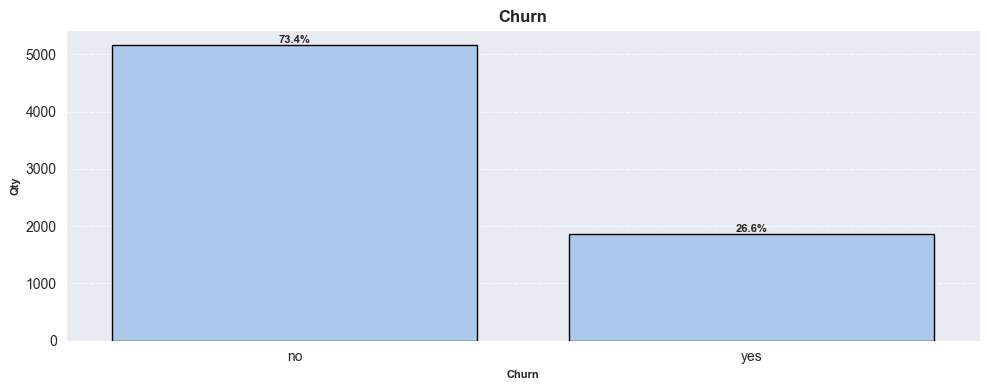

churn
no     5163 | 73.42%
yes    1869 | 26.58%
Name: count, dtype: object


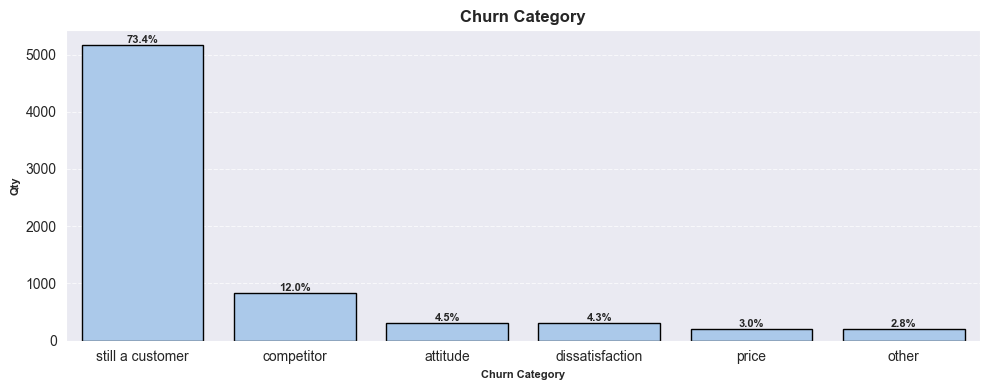

churn_category
still a customer    5163 | 73.42%
competitor           841 | 11.96%
attitude              314 | 4.47%
dissatisfaction       303 | 4.31%
price                  211 | 3.0%
other                 200 | 2.84%
Name: count, dtype: object


In [85]:
for target_type, target_details in target_dict.items():
    for name, target in target_details.items():

        if target_type == 'num_targets':
            create_histplots(data=target.to_frame(), features=[name], ax_cols=1)
            counts = pd.cut(target, bins=10).value_counts(sort=False)
        elif target_type == 'cat_targets':
            create_countplots(data=target.to_frame(), features=[name], ax_cols=1)
            counts = target.value_counts(sort=True)

        percent = (counts / counts.sum())*100
        summary = counts.astype(str) + ' | ' + percent.round(2).astype(str) + '%'
        
        print(summary)
        print('='*60)

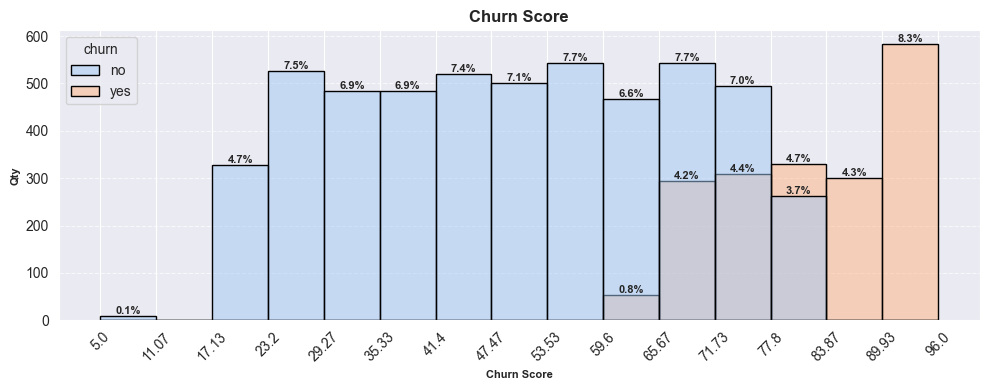

In [86]:
create_histplots(data=data, features=['churn_score'], hue='churn', ax_cols=1, bins=15)

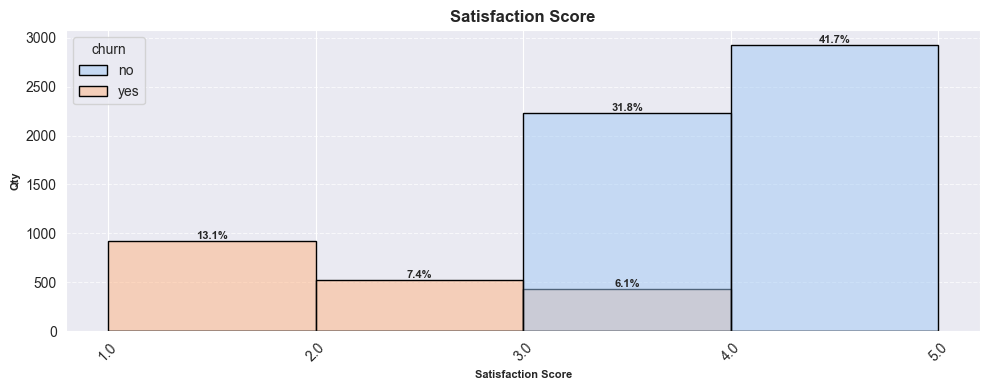

In [185]:
create_histplots(data=data, features=['satisfaction_score'], hue='churn', ax_cols=1, bins=4)

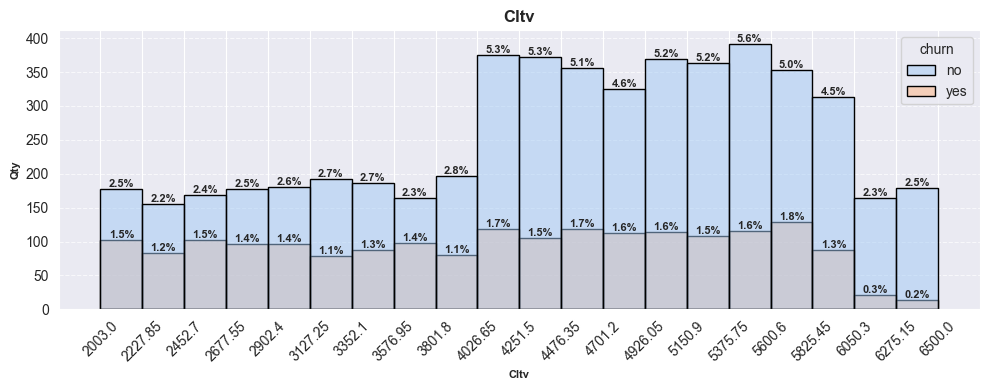

In [279]:
create_histplots(data=data, features=['cltv'], hue='churn', ax_cols=1, bins=20)

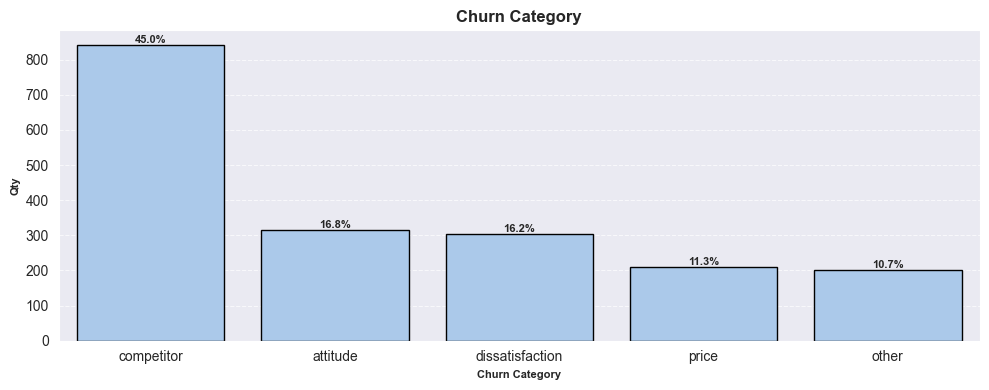

In [197]:
create_countplots(data=data[data['churn_category'] != 'still a customer'], features=['churn_category'], ax_cols=1)

# Preprocessing

## Step Overview

**1. Handling Outliers**
- Evaluate **skewness** and **kurtosis** for applicable features to assess asymmetry and tail behavior.  
- For each case, decide on the appropriate handling strategy: **binning, discretization, removal, flagging, or transformations** (e.g., Yeo-Johnson).  
- Implementen each transformation as a separate **custom transformer** for modularity.  
- Combine all outlier-related transformers into an **`outliers_pipeline`**, which will be the first step in the **final pipeline**.  
- Apply the pipeline to a test copy of the dataset to analyze the distribution metrics (skew, kurtosis) after processing.

**2. Feature Engineering**
- Explore the dataset for opportunities to create additional meaningful features.  
- Build and test **separate transformers** for each newly engineered feature.  
- Combine them into a **`fe_pipeline`**, placed right after `outliers_pipeline` in the final preprocessing flow.  

**3. Transformer Configuration**
- Reviewe previously grouped feature types (7 categories) to determine suitable processing strategies for each group.  
- Identify ordinal features, if any, and define custom mappings where appropriate.  
- Use the `set_preprocessing_pipeline_steps` function to assemble a unified list of steps (`preprocessing_pipeline_steps`) combining outlier handling, feature engineering, and column transformers in reasonable order.  

**4. Multicollinearity Detection**
- Assess **multicollinearity** across numerical features using the `calculate_vif` function.  
- Based on correlation patterns and feature relevance, decide how to address high VIF scores (typically by removing less important, highly correlated features).  
- Add a **custom transformer** to handle such features as the final step in the **preprocessing pipeline**.  


## 8. Handling Outliers

In [88]:
testing_data = data.copy()
outliers_pipeline_steps = []

### Pre-Analysis

In [89]:
skew_instructions = generate_skew_instructions(data=data, features=num_cols)

!HIGH! Skewness found on column "population" with value of 0.91

!HIGH! Skewness found on column "total_charges" with value of 0.96

!EXTRA HIGH! Skewness found on column "total_refunds" with value of 4.32

!HIGH! Skewness found on column "total_revenue" with value of 0.92

!EXTRA HIGH! Skewness found on column "total_extra_data_charges" with value of 4.09

!EXTRA HIGH! Skewness found on column "total_long_distance_charges" with value of 1.24

!EXTRA HIGH! Skewness found on column "avg_monthly_gb_download" with value of 1.22



In [90]:
evaluate_kurtosis(data=data, features=num_cols)

!HIGH! kurtosis found on column Total_refunds with value of 18.31

!HIGH! kurtosis found on column Total_extra_data_charges with value of 16.43



['total_refunds', 'total_extra_data_charges']

### 8.1 Binning of Population

In [91]:
population_bins = [0, 2000, 10000, 35000, data['population'].max()]
population_labels = ['village', 'small_town', 'medium_city', 'big_city']

binner = FixedColumnDiscretization(bins=population_bins, labels=population_labels, feature_name='population')
testing_data = binner.fit_transform(testing_data)

In [92]:
describe_disc_features(data=testing_data, features=['population_binned'])

Describing discrete categorical features:
Column: 'population_binned'
population_binned
medium_city    2358
big_city       1832
village        1672
small_town     1170
Name: count, dtype: int64
4 unique values.
----------------------------------------


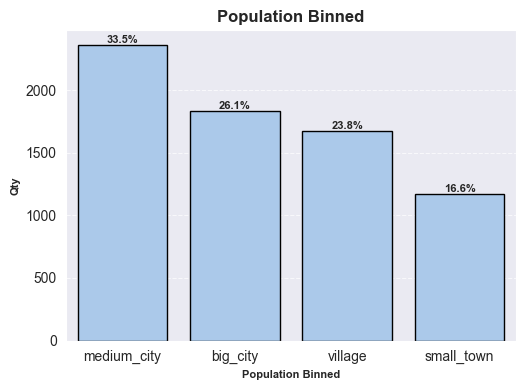

In [93]:
create_countplots(data=testing_data, features=['population_binned'])

In [94]:
outliers_pipeline_steps.append((
    'population_f_disc',
    FixedColumnDiscretization(
        feature_name='population',
        bins=population_bins, 
        labels=population_labels)))

### 8.2 Binning of Total Charges

In [95]:
total_charges_labels = ['extra_low', 'low', 'medium', 'high', 'extra_high']
binner = QuantileColumnDiscretization(feature_name='total_charges', n_bins=5, labels=total_charges_labels, drop_original=True)

In [96]:
testing_data = binner.fit_transform(testing_data)

In [97]:
describe_disc_features(data=testing_data, features=['total_charges_binned'])

Describing discrete categorical features:
Column: 'total_charges_binned'
total_charges_binned
extra_low     1407
extra_high    1407
low           1406
medium        1406
high          1406
Name: count, dtype: int64
5 unique values.
----------------------------------------


In [98]:
outliers_pipeline_steps.append((
    'total_charges_q_disc',
    QuantileColumnDiscretization(
        feature_name='total_charges',
        n_bins=5, 
        labels=total_charges_labels, 
        drop_original=True)))

### 8.3 Flagging Total Refunds

In [99]:
flagger = PositiveValueFlagTransformer(features=['total_refunds'], drop_original=True)

In [100]:
testing_data = flagger.fit_transform(testing_data)

In [101]:
describe_disc_features(data=testing_data, features=['has_total_refunds'])

Describing discrete categorical features:
Column: 'has_total_refunds'
has_total_refunds
0    6507
1     525
Name: count, dtype: int64
2 unique values.
----------------------------------------


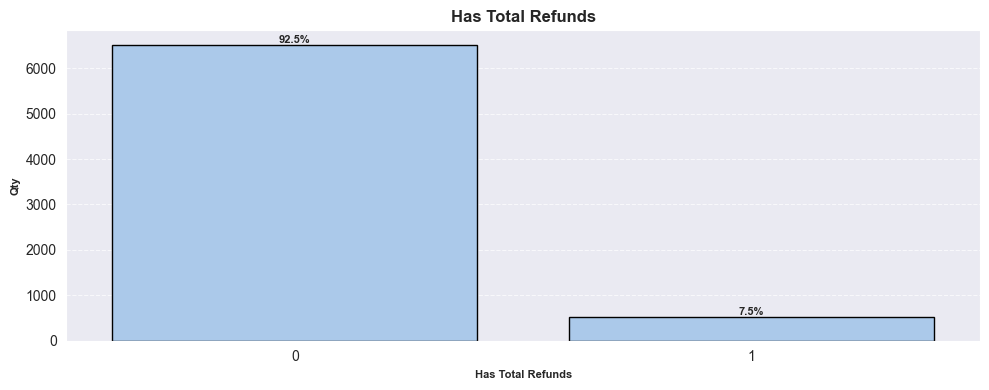

In [102]:
create_countplots(data=testing_data, features=['has_total_refunds'], ax_cols=1)

In [103]:
outliers_pipeline_steps.append((
    'total_refunds_flag',
    PositiveValueFlagTransformer(
        features=['total_refunds'], 
        drop_original=True)))

### 8.4 Binning of total_revenue

In [104]:
total_revenue_labels = ['extra_low', 'low', 'average', 'high']
binner = QuantileColumnDiscretization(feature_name='total_revenue', n_bins=4, labels=total_revenue_labels, drop_original=True)
testing_data = binner.fit_transform(testing_data)

In [105]:
describe_disc_features(data=testing_data, features=['total_revenue_binned'])

Describing discrete categorical features:
Column: 'total_revenue_binned'
total_revenue_binned
extra_low    1758
low          1758
average      1758
high         1758
Name: count, dtype: int64
4 unique values.
----------------------------------------


In [106]:
outliers_pipeline_steps.append((
    'total_revenue_q_disc',
    QuantileColumnDiscretization(
        feature_name='total_revenue',
        n_bins=4, 
        labels=total_revenue_labels, 
        drop_original=True)))

### 8.5 Flagging of total_extra_data_charges

In [107]:
flagger = PositiveValueFlagTransformer(features=["total_extra_data_charges"], drop_original=True)
testing_data = flagger.fit_transform(testing_data)
describe_disc_features(data=testing_data, features=["has_total_extra_data_charges"])

Describing discrete categorical features:
Column: 'has_total_extra_data_charges'
has_total_extra_data_charges
0    6304
1     728
Name: count, dtype: int64
2 unique values.
----------------------------------------


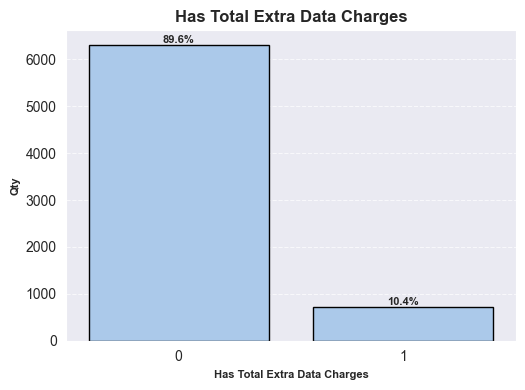

In [108]:
create_countplots(data=testing_data, features=["has_total_extra_data_charges"])

In [109]:
outliers_pipeline_steps.append((
    'total_extra_data_charges_flag',
    PositiveValueFlagTransformer(
        features=['total_extra_data_charges'], 
        drop_original=True)))

### 8.6 Q-Discretization of total_long_distance_charges

In [110]:
total_long_distance_charges_labels = ['extra_low', 'low', 'average', 'high', 'extra_high']
flagger = QuantileColumnDiscretization(feature_name="total_long_distance_charges", labels=total_long_distance_charges_labels, n_bins=5, drop_original=True)

testing_data = flagger.fit_transform(testing_data)
describe_disc_features(data=testing_data, features=["total_long_distance_charges_binned"])

Describing discrete categorical features:
Column: 'total_long_distance_charges_binned'
total_long_distance_charges_binned
extra_low     1407
extra_high    1407
low           1406
average       1406
high          1406
Name: count, dtype: int64
5 unique values.
----------------------------------------


In [111]:
outliers_pipeline_steps.append((
    'long_distance_charges_q_disc', 
    QuantileColumnDiscretization(
        feature_name='total_long_distance_charges',
        labels=total_long_distance_charges_labels, 
        n_bins=5, 
        drop_original=True)))

### 8.7 Skewed Transformation on avg_monthly_gb_download

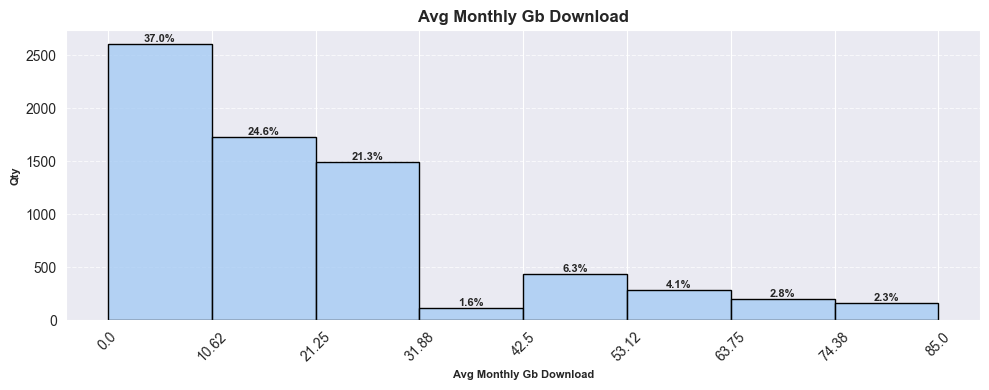

In [112]:
create_histplots(data=testing_data, features=["avg_monthly_gb_download"], ax_cols=1, bins=8)

In [113]:
skew_instruction = generate_skew_instructions(data=testing_data, features=["avg_monthly_gb_download"])

!EXTRA HIGH! Skewness found on column "avg_monthly_gb_download" with value of 1.22



In [114]:
skewed_transformer = SkewedFeaturesTransformer(transform_instructions=skew_instruction, drop_original=True)
testing_data = skewed_transformer.fit_transform(testing_data)
testing_data['avg_monthly_gb_download_yeo-johnson']

0      -0.196618
1       0.155070
2       0.385586
3      -0.196618
4       1.294107
          ...   
7038    0.506517
7039    1.468789
7040    0.204678
7041   -0.344200
7042   -0.129872
Name: avg_monthly_gb_download_yeo-johnson, Length: 7032, dtype: float64

In [115]:
generate_skew_instructions(data=testing_data, features=['avg_monthly_gb_download_yeo-johnson'], detailed=True)

NORMAL Skewness on column "avg_monthly_gb_download_yeo-johnson" with value of -0.16

Skewness of dataset is ok!


{}

In [116]:
outliers_pipeline_steps.append((
    'avg_monthly_gb_skew_transf', 
    SkewedFeaturesTransformer(
        transform_instructions=
        {'avg_monthly_gb_download': 'yeo-johnson'}, 
        drop_original=True)))

### 8.8 --- Outlier Pipeline ---

In [117]:
print(outliers_pipeline_steps)

[('population_f_disc', FixedColumnDiscretization(bins=[0, 2000, 10000, 35000, np.int64(105285)],
                          feature_name='population',
                          labels=['village', 'small_town', 'medium_city',
                                  'big_city'])), ('total_charges_q_disc', QuantileColumnDiscretization(drop_original=True, feature_name='total_charges',
                             labels=['extra_low', 'low', 'medium', 'high',
                                     'extra_high'],
                             n_bins=5)), ('total_refunds_flag', PositiveValueFlagTransformer(drop_original=True, features=['total_refunds'])), ('total_revenue_q_disc', QuantileColumnDiscretization(drop_original=True, feature_name='total_revenue',
                             labels=['extra_low', 'low', 'average', 'high'],
                             n_bins=4)), ('total_extra_data_charges_flag', PositiveValueFlagTransformer(drop_original=True,
                             features=['total_ex

In [118]:
outliers_pipeline = Pipeline(steps=outliers_pipeline_steps)

In [274]:
outliers_pipeline

Pipeline(steps=[('population_f_disc',
                 FixedColumnDiscretization(bins=[0, 2000, 10000, 35000,
                                                 np.int64(105285)],
                                           feature_name='population',
                                           labels=['village', 'small_town',
                                                   'medium_city',
                                                   'big_city'])),
                ('total_charges_q_disc',
                 QuantileColumnDiscretization(drop_original=True,
                                              feature_name='total_charges',
                                              labels=['extra_low', 'low',
                                                      'medium', 'high',
                                                      'extra_high'],
                                              n_...
                                              features=['total_extra_data_charges'])),
                ('long_distance_charges_q_disc',
                 QuantileColumnDiscretization(drop_original=True,
                                              feature_name='total_long_distance_charges',
                                              labels=['extra_low', 'low',
                                                      'average', 'high',
                                                      'extra_high'],
                                              n_bins=5)),
                ('avg_monthly_gb_skew_transf',
                 SkewedFeaturesTransformer(drop_original=True,
                                           transform_instructions={'avg_monthly_gb_download': 'yeo-johnson'}))])

### 8.9 Final Check of Kurt, Skew and Outliers

In [119]:
testing_data = data.drop(columns=['population', 
                            'total_charges',
                            'total_refunds', 
                            'total_extra_data_charges', 
                            'total_revenue',
                            'total_long_distance_charges', 
                            'avg_monthly_gb_download'
                           ]).copy()

In [120]:
test_col_set = classify_columns(data=testing_data, nunique_threshold=12)
test_num_cols = test_col_set['num_cols']

In [121]:
generate_skew_instructions(data=testing_data, features=test_num_cols, detailed=True)

NORMAL Skewness on column "age" with value of 0.16

NORMAL Skewness on column "zip_code" with value of -0.21

NORMAL Skewness on column "latitude" with value of 0.31

NORMAL Skewness on column "longitude" with value of -0.09

NORMAL Skewness on column "tenure_in_months" with value of 0.24

NORMAL Skewness on column "monthly_charge" with value of -0.22

NORMAL Skewness on column "avg_monthly_long_distance_charges" with value of 0.05

NORMAL Skewness on column "churn_score" with value of -0.16

NORMAL Skewness on column "cltv" with value of -0.31

Skewness of dataset is ok!


{}

In [122]:
evaluate_kurtosis(data=testing_data, features=test_num_cols, detailed=True)

NORMAL Kurtosis on column Age with value of -1.00

NORMAL Kurtosis on column Zip_code with value of -1.17

NORMAL Kurtosis on column Latitude with value of -1.16

NORMAL Kurtosis on column Longitude with value of -1.19

NORMAL Kurtosis on column Tenure_in_months with value of -1.39

NORMAL Kurtosis on column Monthly_charge with value of -1.26

NORMAL Kurtosis on column Avg_monthly_long_distance_charges with value of -1.26

NORMAL Kurtosis on column Churn_score with value of -1.09

NORMAL Kurtosis on column Cltv with value of -0.93

Kurtosis of dataset is ok!


[]

In [123]:
identify_outliers(data=testing_data, features=test_num_cols)

No outliers detected using IQR.


set()

## 9. Feature Engineering

In [236]:
feat_eng_pipeline_steps = []
testing_data = data.copy()

### 9.1 did_renew_contract

In [237]:
class RenewedContractFlagTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, tenure_col: str, contract_col: str):
        self.tenure_col = tenure_col
        self.contract_col = contract_col
        self.choices = [1, 1, 1]
        
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    
    def transform(self, X):
        
        if not hasattr(self, 'is_fitted_'):
            raise RuntimeError("You must fit transformer before transform")
        if self.tenure_col not in X.columns:
            raise KeyError(f"Column '{self.tenure_col}' was not found in dataset.")
        if self.contract_col not in X.columns:
            raise KeyError(f"Column '{self.contract_col}' was not found in dataset.")
        
        X_ = X.copy()
        conditions = [
            ((X_[self.contract_col] == 'month-to-month') & (X_[self.tenure_col] > 1)),
            ((X_[self.contract_col] == 'one year') & (X_[self.tenure_col] > 12)),
            ((X_[self.contract_col] == 'two year') & (X_[self.tenure_col] > 24)),
        ]
        X_['did_renew_contract'] = np.select(condlist=conditions, choicelist=self.choices, default=0)
        
        return X_

In [238]:
flagger = RenewedContractFlagTransformer(tenure_col='tenure_in_months', contract_col='contract')
testing_data = flagger.fit_transform(testing_data)

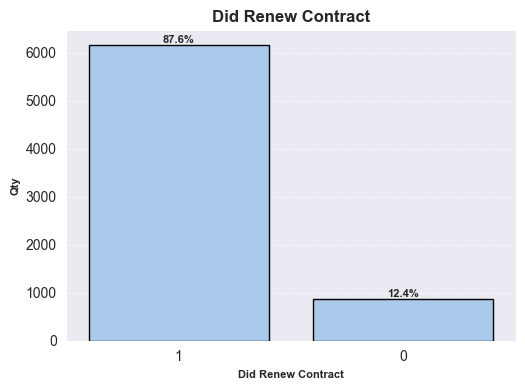

In [239]:
create_countplots(data=testing_data, features=['did_renew_contract'])

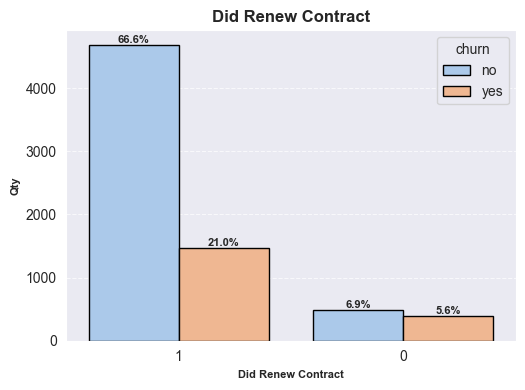

In [241]:
create_countplots(data=testing_data, features=['did_renew_contract'], hue='churn')

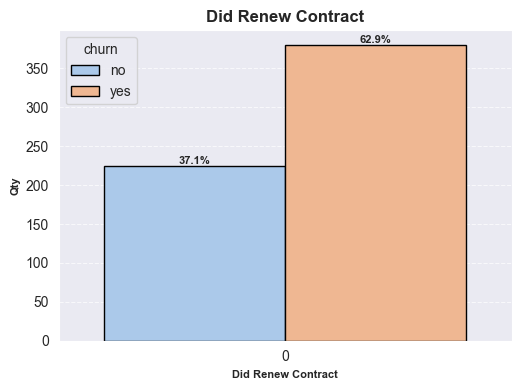

In [252]:
create_countplots(data=testing_data[(testing_data['did_renew_contract'] == 0) & (testing_data['contract'] == 'month-to-month')], features=['did_renew_contract'], hue='churn')

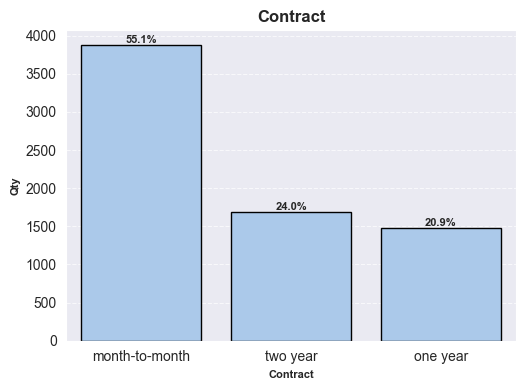

In [250]:
create_countplots(data=testing_data, features=['contract'])

In [128]:
feat_eng_pipeline_steps.append(('did_renew_contract', RenewedContractFlagTransformer(tenure_col='tenure_in_months', contract_col='contract')))

### 9.2 has_active_prepaid_period

In [254]:
class HasActivePrepaidPeriodTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, tenure_col: str, contract_col: str):
        self.tenure_col = tenure_col
        self.contract_col = contract_col
        self.choices = [1, 1]

    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self

    def transform(self, X):
        if not hasattr(self, 'is_fitted_'):
            raise RuntimeError('You must fit transformer before transform')
        if self.tenure_col not in X.columns:
             raise KeyError(f"Column '{self.tenure_col}' was not found in dataset.")
        if self.contract_col not in X.columns:
             raise KeyError(f"Column '{self.contract_col}' was not found in dataset.")

        X_ = X.copy()
        conditions = [
            ((X_[self.contract_col] == 'one year') & ((X_[self.tenure_col] % 12) != 0)),
            ((X_[self.contract_col] == 'two year') & ((X_[self.tenure_col] % 24) != 0))
         ]

        X_['has_active_prepaid_period'] = np.select(condlist=conditions, choicelist=self.choices, default=0)
        
        return X_

In [255]:
flagger = HasActivePrepaidPeriodTransformer(tenure_col='tenure_in_months', contract_col='contract')
testing_data = flagger.fit_transform(testing_data)

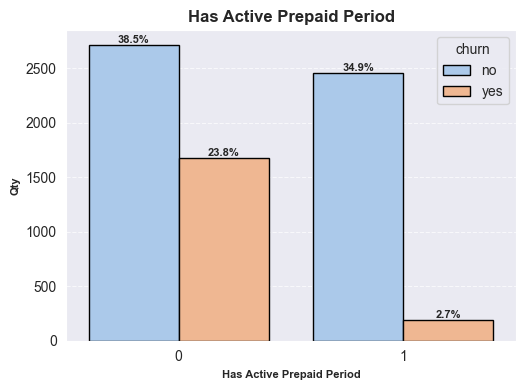

In [256]:
create_countplots(data=testing_data, features=['has_active_prepaid_period'], hue='churn')

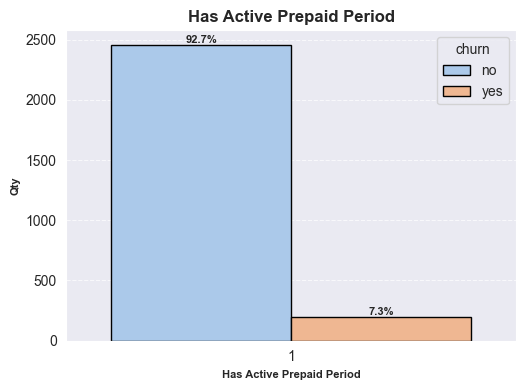

In [257]:
create_countplots(data=testing_data[testing_data['has_active_prepaid_period'] == 1], features=['has_active_prepaid_period'], hue='churn')

In [132]:
np.round(testing_data.groupby('has_active_prepaid_period')['churn_value'].mean(), 2)

has_active_prepaid_period
0    0.38
1    0.07
Name: churn_value, dtype: float64

In [133]:
testing_risky_client = testing_data[(testing_data['has_active_prepaid_period']==1) & (testing_data['churn_value']==1)]

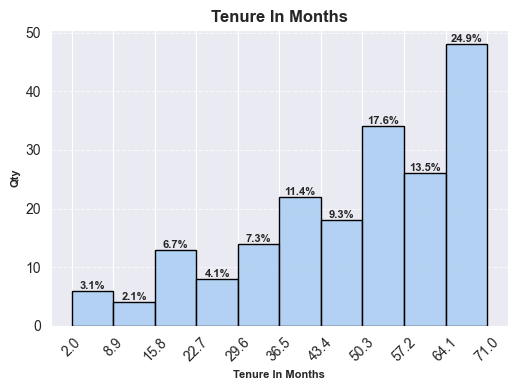

In [258]:
create_histplots(data=testing_risky_client, features=['tenure_in_months'], ax_cols=2)

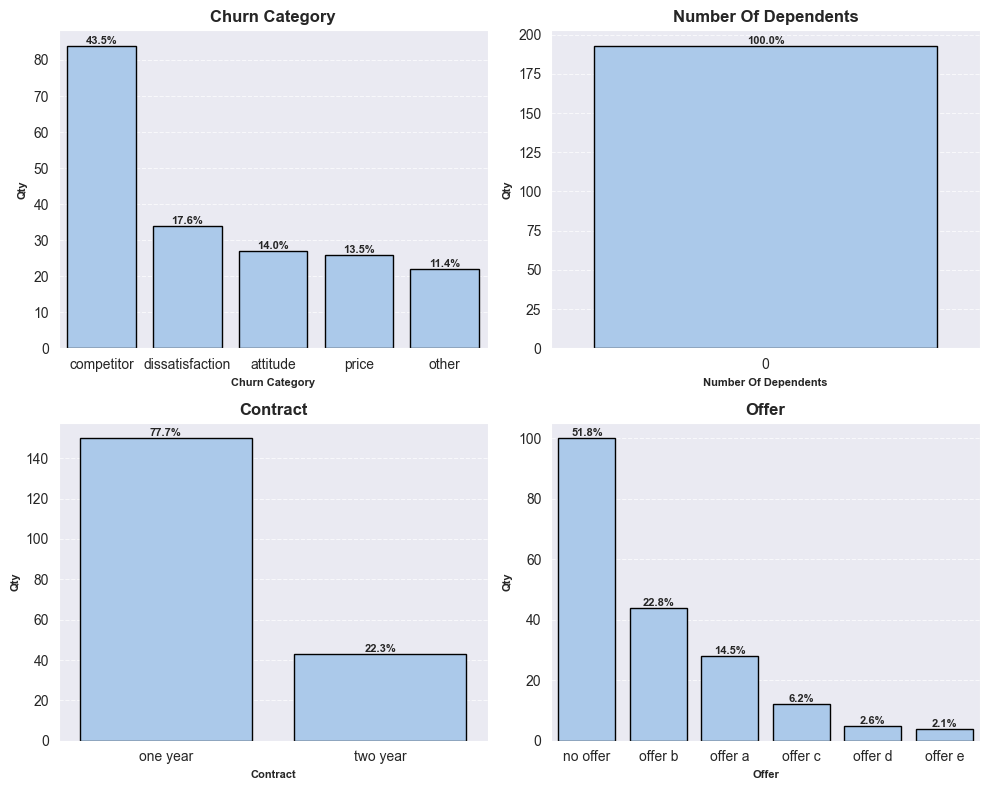

In [261]:
create_countplots(data=testing_risky_client, features=['churn_category','number_of_dependents', 'contract', 'offer'], ax_cols=2)

In [136]:
feat_eng_pipeline_steps.append(('has_active_prepaid_period', HasActivePrepaidPeriodTransformer(tenure_col='tenure_in_months', contract_col='contract')))

### 9.3 binned_tenure

In [137]:
class BinnedTenure(BaseEstimator, TransformerMixin):
    def __init__(self, tenure_col: str, bins_map: dict[str, int], last_category_name: str):
        self.tenure_col = tenure_col
        self.bins_map = bins_map
        self.last_category_name = last_category_name

    def fit(self, X, y=None):       
        
        self.bins_map = dict(sorted(self.bins_map.items(), key=lambda item: item[1]))
        
        previous_threshold = -np.inf
        for threshold in self.bins_map.values():
            if threshold <= previous_threshold:
                raise ValueError('Tresholds in bins_map must ascend monotonically.')
            else:
                previous_threshold = threshold
                
        self.is_fitted_ = True
        return self

    def transform(self, X):
        if not hasattr(self, 'is_fitted_'):
            raise RuntimeError('You must fit transformer before transform')
        if self.tenure_col not in X.columns:
            raise KeyError(f"Column '{self.tenure_col}' was not found in dataset.")

            
        X_ = X.copy()

        choices = []
        conditions = []
        previous_threshold = -np.inf
        for cat_name, threshold in self.bins_map.items():
            conditions.append((X_[self.tenure_col] <= threshold) & ((X_[self.tenure_col] > previous_threshold)))
            choices.append(cat_name)
            previous_threshold = threshold

        conditions.append(X_[self.tenure_col] > previous_threshold)
        choices.append(self.last_category_name)
                
        

        X_['binned_tenure'] = np.select(condlist=conditions, choicelist=choices, default='unknown')
        return X_

In [138]:
binner = BinnedTenure(
    bins_map={'new':6, 'established':12, 'loyal':24}, 
    tenure_col='tenure_in_months', 
    last_category_name = 'very_loyal')

In [139]:
testing_data = binner.fit_transform(testing_data)

In [140]:
describe_disc_features(data=testing_data, features=['binned_tenure'])

Describing discrete categorical features:
Column: 'binned_tenure'
binned_tenure
very_loyal     3833
new            1470
loyal          1024
established     705
Name: count, dtype: int64
4 unique values.
----------------------------------------


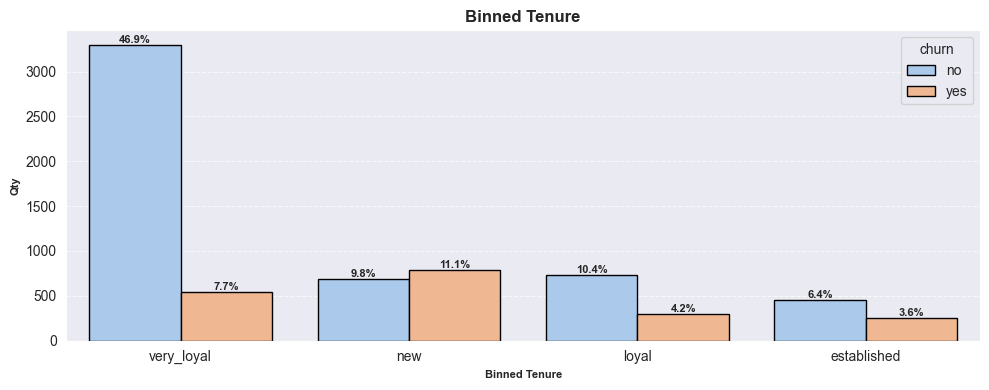

In [141]:
create_countplots(data=testing_data, features=['binned_tenure'], ax_cols=1, hue='churn')

In [142]:
feat_eng_pipeline_steps.append(
    ('binned_tenure', 
     BinnedTenure(
         bins_map={'new':6, 'established':12, 'loyal':24},
         tenure_col='tenure_in_months',
         last_category_name = 'very_loyal')))

### 9.4 services_count

In [263]:
class ServicesCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, internet_col: str, services_cols: list[str]):
        self.internet_col = internet_col
        self.services_cols = services_cols
        
    def fit(self, X, y=None):
        
        if self.internet_col not in X.columns:
            raise KeyError(f"Column '{self.internet_col}' was not found in dataset.")

        missing_columns = [col for col in self.services_cols if col not in X.columns]
        if missing_columns:
            raise KeyError(f"Column(s) '{missing_columns}' was/were not found in dataset.")            
        
        self.is_fitted_ = True
        return self

    def transform(self, X):
        if not hasattr(self, 'is_fitted_'):
            raise RuntimeError('You must fit transformer before transform')

        X_ = X.copy()
        
        X_['services_count'] = ((X_[self.services_cols] == 'yes').sum(axis=1) + (X_[self.internet_col] != 'no internet').astype(int))

        return X_

In [264]:
services_cols = [
    'phone_service',
    'multiple_lines',
    'online_security',
    'online_backup',
    'device_protection_plan',
    'premium_tech_support',
    'streaming_tv',
    'streaming_movies',
    'streaming_music',
    'unlimited_data'
]

In [265]:
counter = ServicesCountTransformer(internet_col='internet_type', services_cols=services_cols)

In [266]:
testing_data = counter.fit_transform(testing_data)

In [267]:
testing_data.groupby('services_count')['churn_value'].mean()

services_count
1     0.088458
2     0.154489
3     0.468992
4     0.424802
5     0.359848
6     0.347935
7     0.304521
8     0.239892
9     0.219466
10    0.103774
11    0.048485
Name: churn_value, dtype: float64

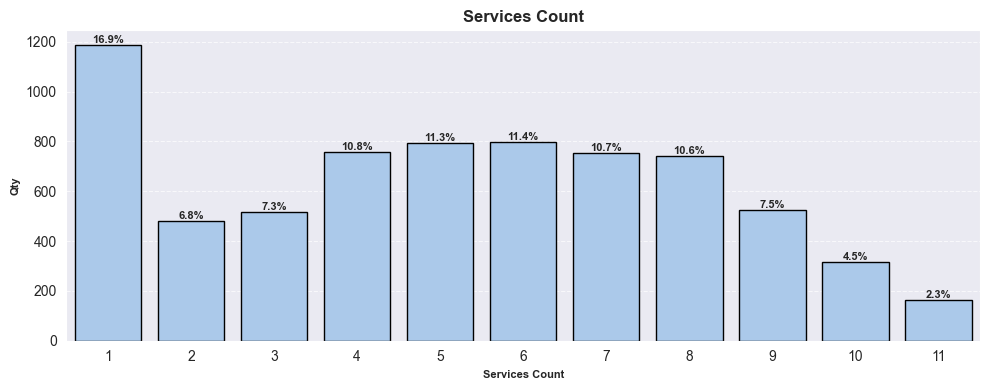

In [268]:
create_countplots(data=testing_data, features=['services_count'], ax_cols=1, is_ordered=True)

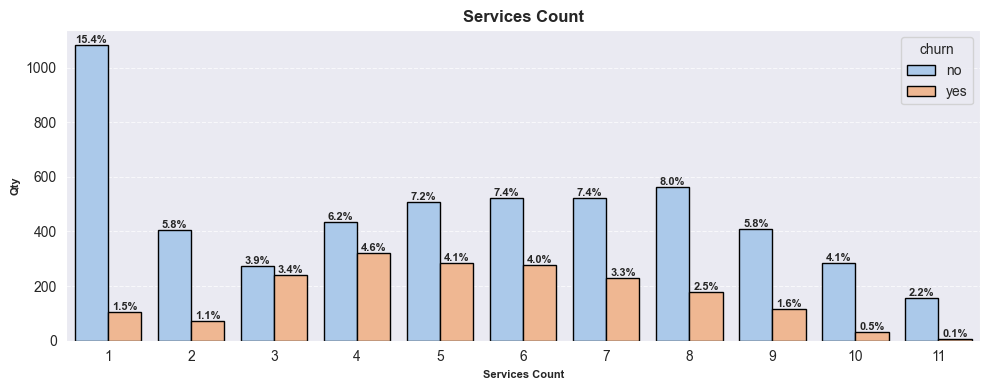

In [269]:
create_countplots(data=testing_data, features=['services_count'], hue='churn', ax_cols=1, is_ordered=True)

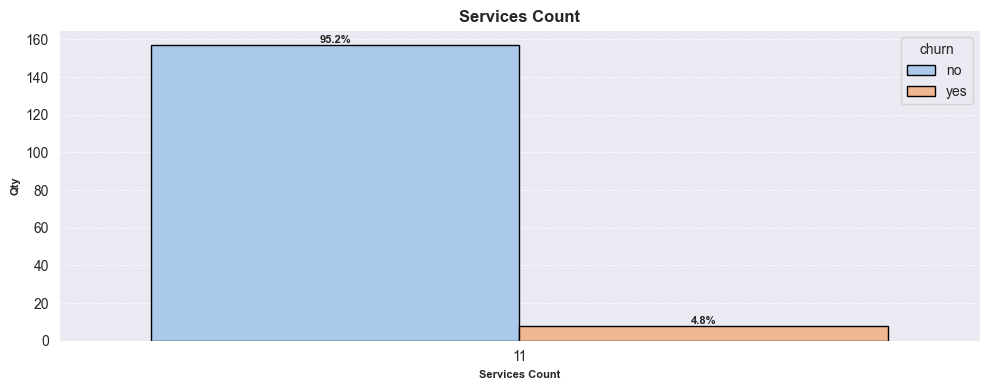

In [271]:
create_countplots(data=testing_data[testing_data['services_count'] == 11], features=['services_count'], hue='churn', ax_cols=1, is_ordered=True)

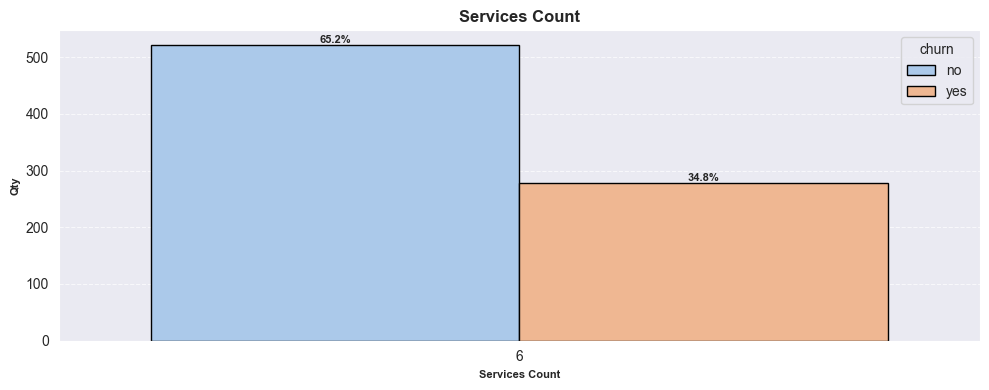

In [273]:
create_countplots(data=testing_data[testing_data['services_count'] == 6], features=['services_count'], hue='churn', ax_cols=1, is_ordered=True)

In [149]:
feat_eng_pipeline_steps.append(('services_count', ServicesCountTransformer(internet_col='internet_type', services_cols=services_cols)))

### 9.5 MappingTransformer

In [150]:
mapping_instruction = {
    'multiple_lines': {
        'yes': 'yes',
        'no': 'no',
        'no phone service': 'no'
    },
    'online_security': {
        'yes': 'yes',
        'no': 'no',
        'no internet service': 'no'
    },
    'online_backup': {
        'yes': 'yes',
        'no': 'no',
        'no internet service': 'no'
    },
    'streaming_tv': {
        'yes': 'yes',
        'no': 'no',
        'no internet service': 'no'
    },
    'streaming_movies': {
        'yes': 'yes',
        'no': 'no',
        'no internet service': 'no'
    }
}

In [151]:
testing_data = MappingTransformer(mapping_instruction=mapping_instruction).fit_transform(testing_data)

In [152]:
feat_eng_pipeline_steps.append(('standart_mapper',MappingTransformer(mapping_instruction=mapping_instruction)))

### 9.6 YesNoToBinaryMapper

In [153]:
yes_no_columns_to_map = [
    'under_30',
    'senior_citizen',
    'partner',
    'paperless_billing',
    'phone_service',
    'multiple_lines',
    'online_security',
    'online_backup',
    'device_protection_plan',
    'premium_tech_support',
    'streaming_tv',
    'streaming_movies',
    'streaming_music', 
    'unlimited_data'
]

In [154]:
feat_eng_pipeline_steps.append(('yes_no_to_binary_mapper',YesNoToBinaryMapper(yes_no_columns=yes_no_columns_to_map)))

### 9.7 UnusedFeaturesDropper

In [155]:
fe_cols_to_drop = ['customer_id','city', 'zip_code', 'latitude', 'longitude','population',]

In [156]:
feat_eng_pipeline_steps.append(('unused_features_dropper', UnusedFeaturesDropper(cols_to_drop=fe_cols_to_drop)))

### --- 9.8 Feature Engineering Pipeline---

In [157]:
fe_pipeline = Pipeline(steps=feat_eng_pipeline_steps)

In [158]:
outlier_fe_pipeline_steps = [
    ('outliers_handling', outliers_pipeline),
    ('feature_engineering', fe_pipeline)
]

## 10. Columns Transformer Settings

In [159]:
testing_data = data.drop(columns=target_list).copy()

In [160]:
ord_disc_cat_cols_mapping = [
    ['village', 'small_town', 'medium_city', 'big_city'],
    ['extra_low', 'low', 'medium', 'high', 'extra_high'],
    ['extra_low', 'low', 'average', 'high'],
    ['extra_low', 'low', 'average', 'high', 'extra_high'],
    ['new', 'established', 'loyal', 'very_loyal']
]
ord_disc_cat_cols = ['population_binned', 'total_charges_binned', 'total_revenue_binned', 'total_long_distance_charges_binned', 'binned_tenure']

In [161]:
preprocessing_pipeline_steps = set_preprocessing_pipeline_steps(
    data=testing_data, 
    previous_pipeline_steps=outlier_fe_pipeline_steps, 
    nunique_threshold=16, 
    verbose_feature_names_out=False,
    ordinal_columns=ord_disc_cat_cols, 
    ordinal_mapping=ord_disc_cat_cols_mapping)

## 11. Multicollinearity Detection

### 11.1 Analysis

In [162]:
testing_data = data.drop(columns=target_list).copy()
preprocessing_pipeline = Pipeline(steps=preprocessing_pipeline_steps)

testing_data = preprocessing_pipeline.fit_transform(testing_data)
vif_report_df, vif_report_dict = calculate_vif(testing_data)

vif_report_df[vif_report_df['vif_grade'] == 'high']

,feature,vif_score,vif_grade
33,streaming_movies,13.518166,high
34,tenure_in_months,14.089459,high
35,total_revenue_binned,15.074187,high
36,has_total_extra_data_charges,15.867806,high
37,streaming_music,16.708033,high
38,total_charges_binned,18.402827,high
39,internet_type_fiber optic,24.088868,high
40,phone_service,44.541821,high
41,internet_type_no internet,75.725433,high
42,unlimited_data,77.461060,high


<Axes: >

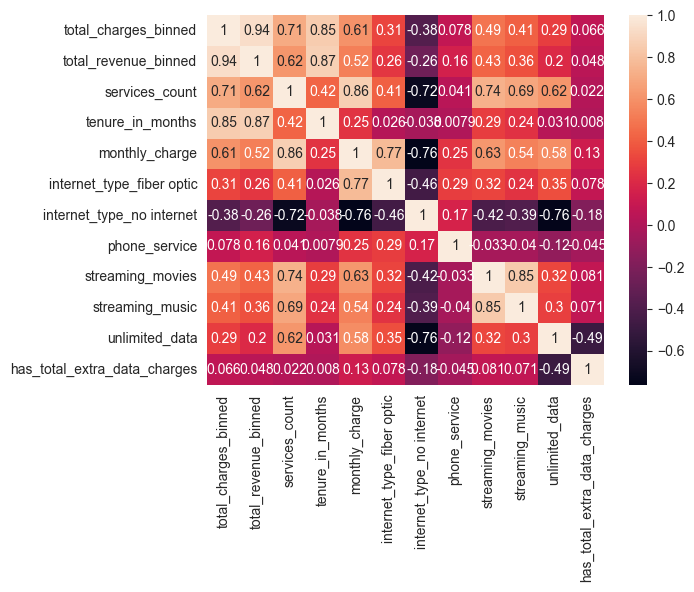

In [163]:
sns.heatmap(testing_data[vif_report_dict['high_vif_cols']].corr(), annot=True)

### 11.2 Handling

In [164]:
vif_cols_to_drop = [
    # strong correlation with monthly_charge and between each other
    'services_count', 
    'internet_type_no internet', 
    'unlimited_data', 
    'phone_service', 
    'internet_type_fiber optic',

    # strong correlation with monthly_charge
    'total_charges_binned', 
    'total_revenue_binned'
]

vif_test_data = testing_data.drop(columns=vif_cols_to_drop).copy()
vif_report_df, vif_report_dict = calculate_vif(vif_test_data)

vif_report_df[vif_report_df['vif_grade'] != 'low']

,feature,vif_score,vif_grade
13,internet_type_dsl,2.057260,moderate
14,premium_tech_support,2.092813,moderate
15,online_backup,2.159481,moderate
16,payment_method_mail check,2.167205,moderate
17,device_protection_plan,2.349440,moderate
18,multiple_lines,2.575476,moderate
19,payment_method_e-check,2.631759,moderate
20,paperless_billing,2.761019,moderate
21,avg_monthly_gb_download_yeo-johnson,2.988155,moderate
22,streaming_tv,3.070567,moderate


In [165]:
high_vif_cols_dropper = UnusedFeaturesDropper(cols_to_drop=vif_cols_to_drop)
preprocessing_pipeline_steps.append(('high_vif_dropper', high_vif_cols_dropper))

# Modeling

## Modeling Step Overview

**1. Target/Feature Split**  
- Separate the dataset into features and target variables.

**2. Feature Selection**  
- Perform feature selection using appropriate methods such as mutual information, chi-squared test, correlation, and ANOVA.  
- Identify two groups of features for experimentation: those that failed at least once and those that consistently underperformed.  
- Add a feature dropper as the final step in the pipeline before the model.

**3. Baseline**  
- Split the dataset into training-validation and final testing sets.  
- Evaluate baseline results according to the task type (regression, binary classification, or multiclass classification).

**4. Benchmark**  
- Create models suitable for the task type.  
- Add each model as the final step in the pipeline and evaluate their performance to compare effectiveness.

**5. Hyperparameter Tuning**  
- Select the best-performing models from the benchmark step.  
- Define parameter grids and perform random grid search to find the optimal hyperparameters for each model.

**6. Final Testing**  
- Assemble models with their best parameters.  
- Conduct final evaluation on the unseen test set.

**7. The Best Model**  
- Choose the most effective model.  
- Select its final parameters.  
- Analyze feature importance to understand which features had the greatest impact on the model.

---
---
---

## **Important Note**

At this stage, we are defining the **sequence in which target variables will be predicted** to ensure optimal performance while strictly avoiding data leakage.

Although the primary purpose of this notebook is to serve as a technical supplement to the final report and therefore does not include detailed explanation of the analysis results, it is important at this point to clearly describe the reasoning behind key modeling decisions. 

This ensures that the notebook itself remains understandable without directly referring to the report. The same explanations will be formally included in the final report, but are provided here to keep the notebook clear and self-contained.


### 1. Targets Order
---
Let's recall that our **list of targets** includes  
`['churn', 'churn_value', 'churn_score', 'churn_category', 'satisfaction_score', 'cltv']`.

The main goal of this project is to identify customers who are likely to leave and stop using Telco's services in the near future. 

Therefore, **`churn_value`** (a numeric interpretation of `churn`: yes = 1, no = 0) will be the **primary target**.  

Other variables, except for `churn_category`, according to our data, are **predictive** or **estimated** rather than factual. For example, `age` is factual, but variables like `satisfaction_score`, `churn_score`, and `cltv` represent predictions or estimates of customer satisfaction, likelihood to churn, or overall customer lifetime value. Because of this, **they cannot be used** directly as features in the main prediction models.  

##### The following approach was decided:

1. Remove all target columns from the dataset and build a model to predict `satisfaction_score`.  
2. Do the same to create a model for predicting `churn_score`.  
3. Similarly, create the main model for predicting `churn_value`. First, build a model without using any target-related features. Then, build a model using the original features in the form of `satisfaction_score` and `churn_score`. Finally, experiment with adding the same, but out-of-fold (OOF) generated features based on previuos steps.
4. Next, filter the dataset to include only customers who churned and build a model to predict `churn_category`.  
5. Finally, use the full dataset to build a model for predicting `cltv`.

### 2. Results Explanation

---
**1. Satisfaction and Churn Scores Predictions**

During this process, we found that **none of the models** could deliver satisfactory results for predicting **`satisfaction_score`** and **`churn_score`**. Their performance was at or barely above **baseline levels**, and the variability in predictions prevented confident use of these models in practice. Various approaches were tried to improve results, including
   - hyperparameter tuning,
   - alternating classification and regression methods for each target,
   - strict and soft feature selection,
   - experimenting with adding original or OOF feaures to each other's features list.

None of these attempts yielded significant improvements, indicating that predicting these targets effectively with the available data is unlikely.

---
**2. Churn Prediction**

Since the previous models failed, **the main strategy for predicting `churn_value` focused on building models without using the previously mentioned target-related features**. This approach achieved an acceptable **F1 score of approximately 0.65**.

Experiments adding original `satisfaction_score` and `churn_score` features **confirmed data leakage**, with prediction accuracy artificially rising to about 99%, which cannot be relied upon due to the predictive nature of these features. Adding generated OOF features did not improve performance and in fact worsened the results, which is consistent with the poor predictability of these features demonstrated earlier.

---
**3. Other Targets**

Subsequent modeling of `churn_category` and `cltv` also yielded poor results, with models barely surpassing baseline scores by a few percentage points and showing high error rates. Similar approaches as outlined in the first point were attempted; however, these efforts failed to yield meaningful improvements.

---
**Conclusion**

Conclusions from these experiments are detailed in the final report. In this notebook for clearer communication, it was decided to include only the `churn_value` prediction, as it was the primary and the only target with meaningful and reliable results. Including unsuccessful models and tests for other targets was considered unnecessary and overcomplicated the analysis without adding value. Therefore, despite having a broad set of targets, the **modeling section focuses solely on predicting the primary target - `churn_value`**.


## 12. Churn: Benchmark

#### Target/Feature Split

In [284]:
y_churn = data['churn_value'].copy()
X_churn = data.drop(columns=target_list).copy()

#### Feature Selection

In [285]:
testing_churn = X_churn.copy()

# set up encoder only
ct_encoder = set_encoding_col_transformer(
    data=testing_churn,
    previous_pipeline_steps = outlier_fe_pipeline_steps,
    ordinal_columns=ord_disc_cat_cols,
    ordinal_mapping=ord_disc_cat_cols_mapping ,
    verbose_feature_names_out=False,
    nunique_threshold=16
)
fs_pipeline_steps_churn = deepcopy(outlier_fe_pipeline_steps)

# add encoder and high-vif-dropper
fs_pipeline_steps_churn.append(('ct_encoder', ArrayToDFTransformer(ct_encoder)))
fs_pipeline_steps_churn.append(('high_vif_dropper', high_vif_cols_dropper))
fs_pipeline_churn = Pipeline(steps=fs_pipeline_steps_churn)

# apply feature selection pipeline to data copy for analysis purpose only
testing_churn = fs_pipeline_churn.fit_transform(testing_churn)


_, weak_cols_churn, no_success_cols_churn = feature_selection_orchestrator(data=testing_churn, target=y_churn, nunique_threshold=15)

In [286]:
churn_prep_pipeline_steps = deepcopy(preprocessing_pipeline_steps)
churn_prep_pipeline_steps.append(('feat_selection_dropper', UnusedFeaturesDropper(cols_to_drop=weak_cols_churn)))

#### Baseline

In [287]:
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X_churn, y_churn, random_state=100, test_size=0.25)

get_baseline_scores(
    X=X_train_churn,
    y=y_train_churn,
    task='binary_class',
    test_size=0.25,
    random_state=100,
    stratify_y=True,
)

,Model,F1 Score,Accuracy,Precision,Recall,ROC AUC,Log Loss
0,dummy_uniform,0.361,0.513,0.275,0.528,0.500,0.693
1,dummy_stratified,0.278,0.633,0.286,0.270,0.516,13.226
2,dummy_most_frequent,0.000,0.738,0.000,0.000,0.500,9.428


#### Benchmark

In [288]:
churn_benchmark_scores = evaluate_binary_class_models(
    models=create_basic_models(
        task='binary_class', 
        random_state=100
    ), 
    random_state=50, 
    test_size=0.25, 
    X=X_train_churn, 
    y=y_train_churn, 
    prep_pipeline_steps=churn_prep_pipeline_steps,
    stratify_y=True)
churn_benchmark_scores

,Model,F1 Score,Accuracy,Precision,Recall,ROC AUC,Log Loss
0,XGBClassifier,0.657,0.829,0.690,0.626,0.875,0.378
1,LogisticRegression,0.652,0.770,0.540,0.823,0.875,0.448
2,LinearSVC,0.648,0.766,0.534,0.823,NaN,NaN
3,LGBMClassifier,0.642,0.823,0.680,0.609,0.875,0.379
4,SGDLogisticClassifier,0.634,0.734,0.495,0.881,0.862,0.602
5,RandomForestClassifier,0.617,0.816,0.676,0.568,0.858,0.474
6,KNeighborsClassifier,0.591,0.791,0.605,0.577,0.815,1.691
7,ExtraTreesClassifier,0.585,0.798,0.631,0.545,0.838,0.649
8,DecisionTreeClassifier,0.533,0.760,0.542,0.525,0.684,8.663


## 13. Churn: Hyperparameters Tunning

In [289]:
grid_res_df_churn = do_random_grid_search(
    X=X_train_churn,
    y=y_train_churn,
    task = 'binary_class',
    prep_pipeline_steps=churn_prep_pipeline_steps,
    models=churn_benchmark_scores.loc[0:2, 'Model'].values.tolist(),
    random_state=150,
    n_iter_min=200,
    cv=5,
    test_size=0.25,
    stratify_y=True
) 

In [290]:
grid_res_df_churn

,model,best_params,f1
0,XGBClassifier,"{'estimator__subsample': 1.0, 'estimator__reg_...",0.673454
1,LinearSVC,"{'estimator__penalty': 'l2', 'estimator__max_i...",0.661410
2,LogisticRegression,"{'estimator__solver': 'saga', 'estimator__pena...",0.660365


## 14. Churn: Final Testing

In [291]:
final_models_churn = assemble_models_after_grid_search(
    task='binary_class',
    models_names_list=grid_res_df_churn['model'].values.tolist(),
    random_state=100,
    parametes_res_df=grid_res_df_churn
)

evaluate_final_binary_class_models(
    X_train=X_train_churn,
    X_test=X_test_churn,
    y_train=y_train_churn,
    y_test=y_test_churn,
    prep_pipeline_steps=churn_prep_pipeline_steps,
    models=final_models_churn
)

,Model,F1 Score,Accuracy,Precision,Recall,ROC AUC,Log Loss
0,XGBClassifier,0.652,0.820,0.708,0.604,0.881,0.378
1,LinearSVC,0.631,0.810,0.688,0.582,NaN,NaN
2,LogisticRegression,0.629,0.811,0.696,0.573,0.871,0.391


## 15. Churn: The Best Model

In [292]:
best_churn_model = assemble_models_after_grid_search(
    task='binary_class',
    models_names_list=['XGBClassifier'],
    random_state=100,
    parametes_res_df=grid_res_df_churn
)['XGBClassifier']


churn_final_pipeline_steps = churn_prep_pipeline_steps + [('estimator', best_churn_model)]
churn_final_pipeline = Pipeline(steps=churn_final_pipeline_steps)
churn_final_pipeline.fit(X_train_churn, y_train_churn)

churn_importance_df = pd.DataFrame({
    'Feature':Pipeline(steps=churn_prep_pipeline_steps).fit_transform(X_train_churn).columns.tolist(),
    'Importance':churn_final_pipeline.named_steps['estimator'].feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

In [295]:
churn_importance_df_filtred = churn_importance_df[churn_importance_df['Importance'] >=0.005]
churn_importance_df_filtred

,Feature,Importance
0,contract_two year,0.208867
1,has_active_prepaid_period,0.164184
2,contract_one year,0.134422
3,payment_method_e-check,0.087526
4,binned_tenure,0.077236
5,number_of_referrals,0.059120
6,number_of_dependents,0.051362
7,avg_monthly_gb_download_yeo-johnson,0.040370
8,tenure_in_months,0.035328
9,paperless_billing,0.030725


In [ ]:
non_default_params = {}
for param_name, param_value in churn_final_pipeline.named_steps['estimator'].get_params().items():
    if XGBClassifier().get_params().get(param_name) != param_value:
        non_default_params[param_name] = param_value

In [ ]:
non_default_params

## 16. Finalization

**1. Top-Model**

Based on the results of our work, we can conclude that among the targets, **the most predictable was `churn` or `churn_value`**. 
The best performing model for predicting customer churn in this project is the **XGBClassifier**. This model demonstrated a balanced trade-off between precision and recall, achieving an **F1 score of 0.652**, which is acceptable for churn prediction tasks in a complex but still incomplete dataset. While the dataset includes a variety of behavioral and service-related features, it lacks direct indicators of customer satisfaction or engagement trends. Expanding the feature space with more detailed customer feedback metrics or time-based usage patterns could further improve the model's ability to capture early signs of churn - and potentially make the prediction of other targets (such as `churn_category` or `cltv`) more relevant and reliable.

**2. Hyperparameters**

The best hyperparameters for our XGBClassifier:

---
``` python
{'colsample_bytree': 0.8,
 'eval_metric': 'logloss',
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'missing': nan,
 'n_jobs': -1,
 'random_state': 100,
 'reg_alpha': 0,
 'reg_lambda': 10,
 'subsample': 1.0}
```
---
These hyperparameters reflect a conservative tree complexity (`max_depth=3`) and moderate regularization (`reg_lambda=10`), which help prevent overfitting given the nature of the data and the absence of leakage from related target features.


--- 
### Comprehensive analytical conclusions and business insights can be found in the text report.  
#### This stage marks the completion of the technical phase of the work.  
#### Thank you for your attention.

# Credits
---
**Author:** Oleksandr Yepur  
**Date:** June 24 2025  